# Global sensitivity analysis. A flood case study.

In [1]:
## Computer experiments course.
## O. Roustant (INSA Toulouse), with contributions from B. Iooss (EDF & IMT)

We consider a simplified first model simulating flooding events.
The model has $8$ input random variables, viewed as random variables:

* $X_{1} = Q$, Maximal annual flowrate (m$^3$/s), Gumbel ${\mathcal G}(1013, 558)$ truncated on $[500 , 3000 ]$
* $X_{2}=K_s$, Strickler coefficient, Normal ${\mathcal N}(30, 8^2)$ truncated on $[15 , +\infty [$
* $X_{3} = Z_v$, River downstream level (m), Triangular ${\mathcal T}(49, 51)$ 
* $X_{4} = Z_m$, River upstream level (m), Triangular  ${\mathcal T}(54, 56)$
* $X_{5} = H_d$, Dyke height (m),  Uniform ${\mathcal U}[7, 9]$ 
* $X_{6} = C_b$, Bank level (m), Triangular ${\mathcal T}(55, 56)$
* $X_{7} = L$, River stretch (m), Triangular ${\mathcal T}(4990, 5010)$
* $X_{8} = B$, River width (m), Triangular ${\mathcal T}(295, 305)$

We consider two variables of interest. First, the maximal annual overflow $S$ (in meters), obtained from simplified hydro-dynamical equations of Saint-Venant:
\begin{equation}
S = \left(\frac{Q}{BK_s \sqrt{\frac{Z_m-Z_v}{L} }} \right)^{0.6} + Z_v - H_d - C_b \,.
\end{equation}
Secondly, the cost (in million euros) of the damage on the dyke $Y$, depending on $S$, written as:
\begin{equation}
Y = 1_{S>0} +  \left[0.2 + 0.8\left( 1-\exp^{-\frac{1000}{S^4}}\right) \right] 1_{S \leq 0} + \frac{1}{20}\left(H_d 1_{H_d>8} + 8 1_{H_d \leq 8} \right) \,,
\end{equation}
where $1_{A}(x)$ is the indicator function which is equal to 1 for $x \in A$ and 0 otherwise.
The aim is to perform a global sensitivity analysis for $S$ and $Y$. In particular, we would like to detect the non-essential input variables and the active subspaces.


In [2]:
# Input names
floodInputNames <- c("Q", "Ks", "Zv", "Zm", "Hd", "Cb", "L", "B")
floodOutputNames <- c("Subverse", "Cost")

# Flood model
flood <- function(X, ans = 0){ 
    # ans = 1 gives Overflow output; ans = 2 gives Cost output; ans=0 gives both
    mat <- as.matrix(X, ncol = 8)
    if (ans == 0) {
        output <- matrix(NA, nrow(mat), 2)
    } else { 
        output <- rep(NA, nrow(mat))
    }
    for (i in 1:nrow(mat)){
        H <- (mat[i, 1] / (mat[i, 2] * mat[i, 8] * sqrt((mat[i, 4] - mat[i, 3]) / mat[i, 7])))^0.6
        S <- mat[i, 3] + H - mat[i, 5] - mat[i, 6] 
    if (S > 0){ 
        Cp <- 1
    } else { 
        Cp <- 0.2 + 0.8 * (1 - exp(- 1000 / S^4))
    }
    if (mat[i, 5] > 8){
        Cp <- Cp + mat[i, 5] / 20 
    } else { 
        Cp = Cp + 8 / 20
    }
    if (ans == 0){
        output[i, 1] <- S ;
        output[i, 2] <- Cp ;
    }
    if (ans == 1) output[i] <- S
    if (ans == 2) output[i] <- Cp 
    }
    return(output)
}

In [3]:
# Function for flood model inputs sampling
library(sensitivity) # (truncated) Gumbel law and truncated Normal law
library(triangle) # Triangular law

floodSample <- function(size){
    X <- matrix(NA, size, 8)
    X[, 1] <- rgumbel.trunc(size, loc = 1013, scale = 558, min = 500, max = 3000)
    X[, 2] <- rnorm.trunc(size, mean = 30, sd = 8, min = 15)
    X[, 3] <- rtriangle(size, a = 49, b = 51)
    X[, 4] <- rtriangle(size, a = 54, b = 56)
    X[, 5] <- runif(size, min = 7, max = 9)
    X[, 6] <- rtriangle(size, a = 55, b = 56)
    X[, 7] <- rtriangle(size, a = 4990, b = 5010)
    X[, 8] <- rtriangle(size, a = 295, b = 305)
    return(X)
}

Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr



# Questions

First select the output 1 (Subverse). The aim is to perform a global sensitivity analysis (GSA) in order the discover what are the most influential inputs, the unessential ones, to visualize the input-output relationship and to quantify the importance of the inputs on the outputs. For the sake of reproducibility, fix the seed to 0 each time a random sampling is done (in R: set.seed(0)).

## GSA with an unlimited budget
We first consider the case of an unlimited budget. Thus we choose a large sample size $N = 5\,000$ (for instance). 

1. Simulate a sample of size $N$ of the inputs by Monte Carlo and compute the corresponding output (use the R functions "floodSample" and "flood"). Store the sample in a matrix called $X$, and the output values in a vector called $Y$. Plot the output versus the inputs. Comment the results: what is the form of the input-output relationship?  


2. Estimate the global mean. Estimate the main effects with local polynomial regression (use the R function "loess"). Adapt the previous matrix of graphs to superimpose the main effects.  


3. Estimate the Sobol indices with the R function "sobolJansen" (package "sensitivity"). Plot the results and comment them: what are the most influential variables? Are there interactions? Between which variables?


## GSA with a limited budget
Now we want to retrieve these results with a limited budget, say $n = 10d$ where $d = 8$ is the inputs dimension.
To reach that goal, we do three steps: (a) create a design of experiments, (b) build a Gaussian process metamodel, (c) perform the GSA on the metamodel. We adopt a "goal-oriented" strategy, meaning that we aim the metamodel to be accurate when the probability distribution of the inputs is taken into account.

4. We first choose carefully a design of experiments of size $n$. 
a) What are the main drawbacks of Monte Carlo sampling with a small sample size? Explain why it is not possible to use a full factorial design here ; even if it were possible, recall why it is not a good idea, in relation to question 3.   
b) To overcome these drawbacks, create a space-filling design as a Sobol sequence. This first design is well suited for uniform distributions. Use the quantile transformation to deduce a design of experiments, called $Xtrain$, such that marginal distribution of the inputs is correct; for that create a function called "floodQuantile" by adapting the function "floodSample" above. Visualize the result with a scatterplot (with histograms on the diagonal) and compare (visually) with Monte Carlo sampling (function "floodSample").  

5. Compute the output values corresponding to $Xtrain$ and store them in a vector called $Ytrain$. Estimate a Gaussian process metamodel (or kriging model) with function "km" (R package "DiceKriging"). What is the kernel used by default? Comment briefly the model validity by using the diagnostics proposed in function "plot". Compute its performance on the sample $X$, used as a test set: plot the predicted values versus the true ones (stored in $Y$). Compute the $Q^2$ criterion defined by 
$$Q^2(Y, \hat{Y}) = 1 - \frac{\Vert Y - \hat{Y} \Vert^2}{\Vert Y - \bar{Y} \Vert^2} $$
where the norm is the Euclidean norm, and $\bar{Y}$ is the mean of $Y$. Thus $Q^2$ compares the performance of the predictions $\hat{Y}$ compared to what would be predicted by the constant prediction equal to the mean.

6. Compare the performance of the GP metamodel with a naive linear model (first-order polynomial). When the output is the cost, add $H_d^2$ to the covariates of this linear model (explain why it is reasonable). For that, plot the predictions versus the true values, and compute the $Q^2$ criterion as well.

7. Perform a GSA on the mean of the GP metamodel (kriging mean) by doing questions 1-3 for it. Compare these results to the unlimited budget case.

## Metamodeling improvements and physics-informed Gaussian process

To improve the metamodeling step, we bring some information contained in the equations defining the subverse and the cost.

8. Consider the output "subverse". Play with function 'km' in order to add a linear trend to the GP model. Check that this model outperforms the basic GP, by plotting the prediction on the test set (here $X$) versus the true value, and computing the $Q^2$ criterion. Redo question 7 for this model. Comment?

9. Knowing the equation of the ouput "cost", we see that a suitable GP should have the form 
$$Y(S, H_d) = Y_1(S) + Y_2(H_d)$$
Assuming that $Y_1, Y_2$ are independent Gaussian processes with kernels $k_1, k_2$, what form should have the kernel of $Y$? Estimate this new GP with function "kmAdditive", from the R package fanovaGraph, still using $Xtrain$ as a desing of experiments. Check that this model outperforms the basic GP. Compare also with a GP depending on $S$ and $H_d$. However, explain why it seems difficult to use this approach for global sensitivity analysis with respect to the original variables.

## At least one theoretical computation

10. For the output "S", compute theoretically the main effect with respect to the variable $H_d$. Compare with 3)a). Same question for $C_b$.


## Starter

In [4]:
myOutput <- 1  # 1 for subverse, 2 for cost

## Q1. & Q2.
The figure shows that some variables: $L$, $B$ and $Z_m$ have little to no main effect which is illustrated by a constant line. The main effect of the other variables ($Q$, $K_s$, $Z_v$, $H_d$ and $C_b$) is visible and varies in intensity. The main effects in some cases look linear, in other cases such as $K_s$ we notice an exponential-like main effect.

The form of the main effect was previsible in the case of $C_b$, $Z_v$ and $H_d$, because of the linear effect in the formula to calculate $S$ and the abscence of interaction with other variables, since all the variables were simulated independently.

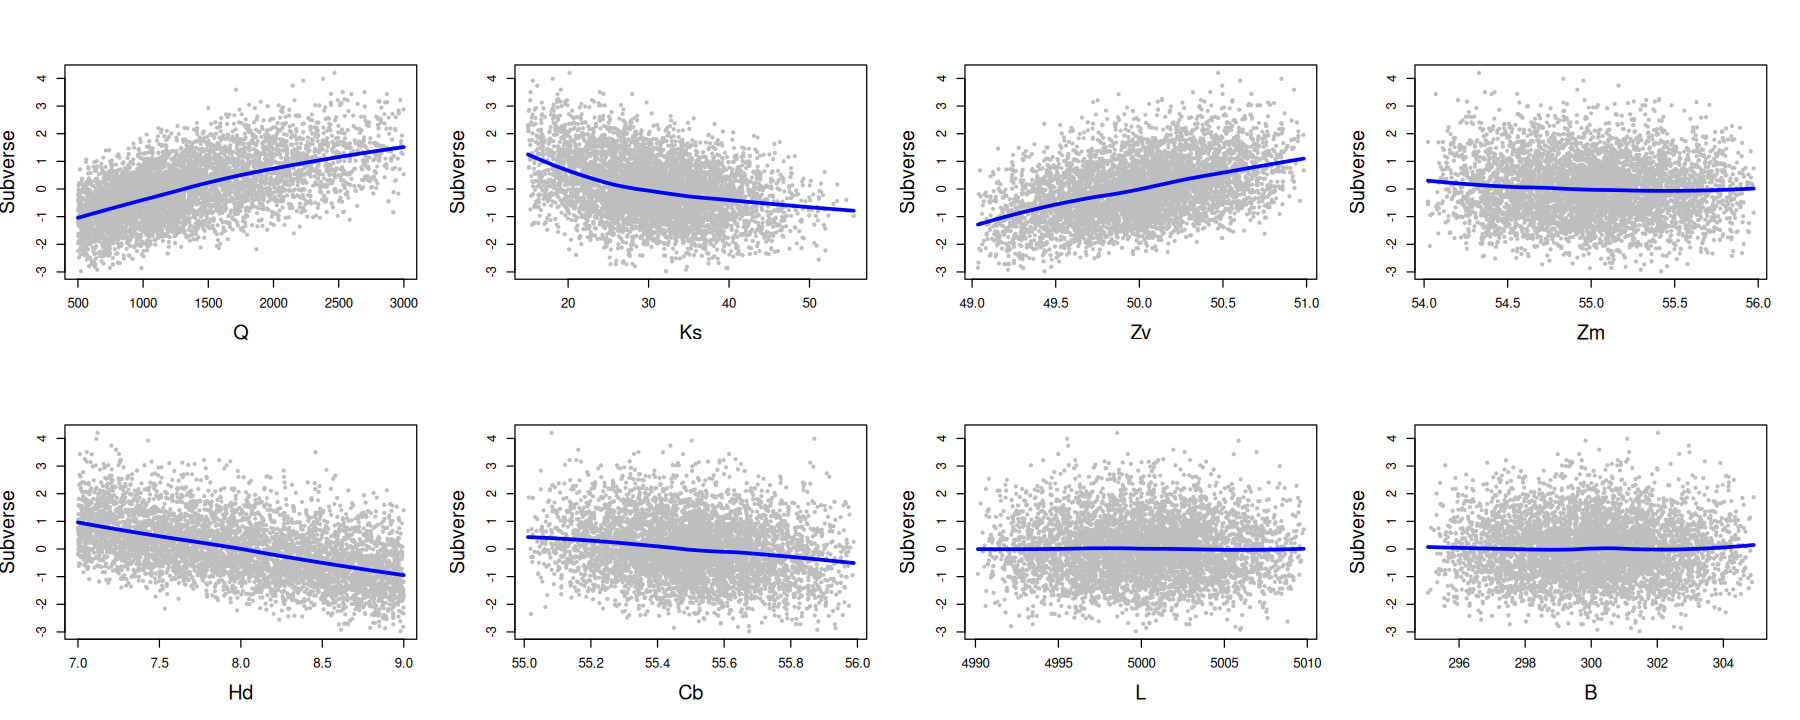

In [5]:
# Help for questions 1 and 2

N <- 5000  # to be upgraded
set.seed(0); X <- floodSample(N); colnames(X) <- floodInputNames
Y <- flood(X, ans = myOutput)
Ymean <- mean(Y)
Ycentered = Y - Ymean
par(mfrow = c(2, 4))
options(repr.plot.width = 15, repr.plot.height = 6)

# the next lines must be slightly adapted, there are not exactly suited to represent the main effects
for (i in 1:8){
    plot(Ycentered ~ X[, i], xlab = floodInputNames[i], ylab = floodOutputNames[myOutput], 
         pch = 19, col = "grey", cex = 0.5, cex.lab = 1.5)
    ss <- loess(Ycentered ~ X[, i])
    t <- seq(from = min(X[, i]), to = max(X[, i]), length = 100)
    lines(t, predict(ss, t), col = "blue", lwd = 3)
}


## Q3.
The most influential variables are $Q$, $H_d$, $Z_v$ and $K_s$. However, $Z_b$, $L$ and $B$ have almost no influence on the subverse and can be considered inactive variables.\
The plot also shows that there is very little interaction between the variables, because the main effect and total effect indices are very close for each variable.

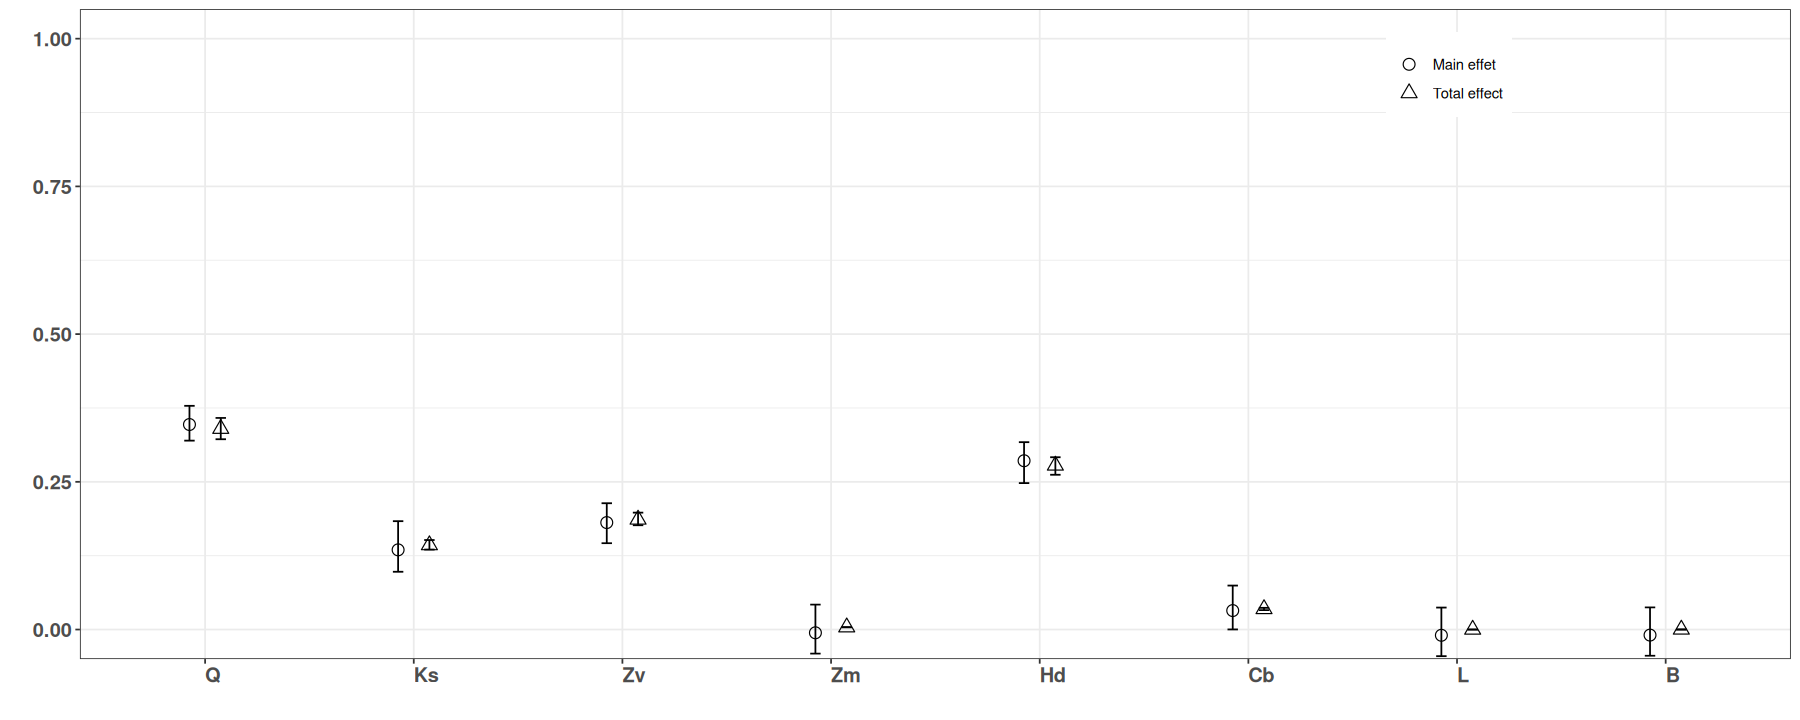

In [6]:
# Help for question 3

library(boot)
# we use a pick-freeze formula (Sobol Jansen), which requires two samples
X1 <- floodSample(N)
X2 <- floodSample(N)
X1 <- data.frame(X1); names(X1) <- floodInputNames
X2 <- data.frame(X2); names(X2) <- floodInputNames

# sensitivity analysis
## to be completed 
SAresult <- soboljansen(model = flood, X1, X2, nboot = 100, ans = myOutput)
totalIndex <- SAresult$T$original; names(totalIndex) <- floodInputNames
sobolIndex <- SAresult$S$original; names(sobolIndex) <- floodInputNames

library(ggplot2)
ggplot(SAresult)

## GSA with a limited budget
Now we want to retrieve these results with a limited budget, say $n = 10d$ where $d = 8$ is the inputs dimension.
To reach that goal, we do three steps: (a) create a design of experiments, (b) build a Gaussian process metamodel, (c) perform the GSA on the metamodel. We adopt a "goal-oriented" strategy, meaning that we aim the metamodel to be accurate when the probability distribution of the inputs is taken into account.

4. We first choose carefully a design of experiments of size $n$. 
a) What are the main drawbacks of Monte Carlo sampling with a small sample size? Explain why it is not possible to use a full factorial design here ; even if it were possible, recall why it is not a good idea, in relation to question 3.   
b) To overcome these drawbacks, create a space-filling design as a Sobol sequence. This first design is well suited for uniform distributions. Use the quantile transformation to deduce a design of experiments, called $Xtrain$, such that marginal distribution of the inputs is correct; for that create a function called "floodQuantile" by adapting the function "floodSample" above. Visualize the result with a scatterplot (with histograms on the diagonal) and compare (visually) with Monte Carlo sampling (function "floodSample").  

## Q4.
- a) The drawbacks of Monte-Carlo sampling with little $n$ are the convergence speed of this method which is of $\mathcal{O} (\frac{1}{ \sqrt{n} })$. Which means that with a small number of realisations, we can be very far from convergence. The use of full-factorial design is not possible here because there is an infinite number of combinations due to the continuous nature of the variables. Even if it was possible, a full factorial design is very costly in terms of number of experiments which grows exponentially with the number of inputs.

- b).

Loading required package: rngWELL

This is randtoolbox. For an overview, type 'help("randtoolbox")'.


Attaching package: ‘randtoolbox’


The following object is masked from ‘package:sensitivity’:

    sobol




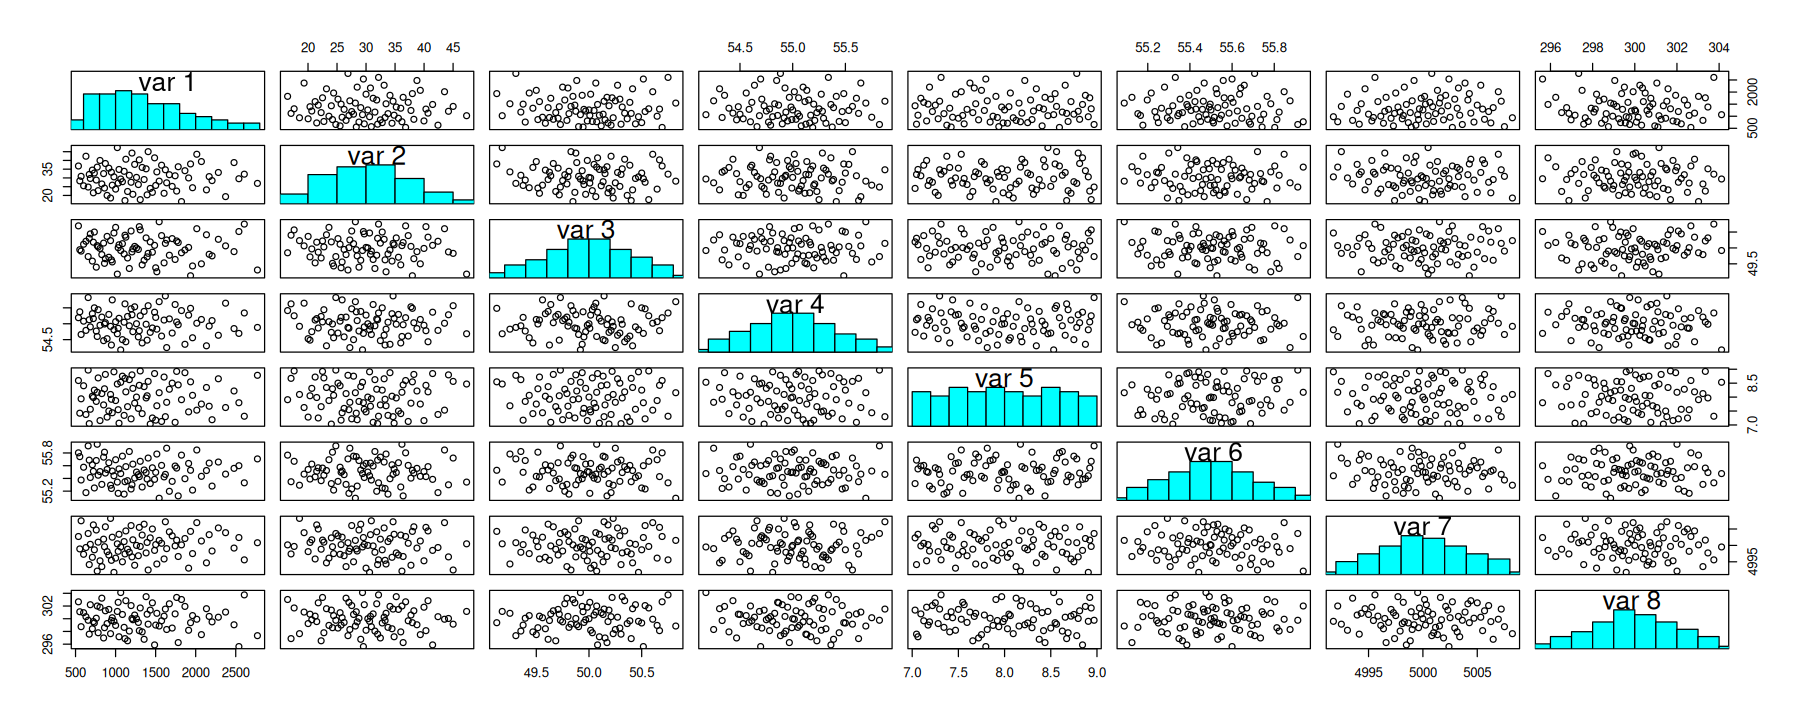

In [7]:
# Help for question 4

library(DiceDesign)
library(randtoolbox)
# ?sobol # What kind of scrambling is the best here? See also rss2d

d <- 8

N <- 10 * d

# skeleton of function floodQuantile
floodQuantile <- function(M) {
  # M=sobol(n, size,)
  X <- matrix(NA, nrow = nrow(M), ncol = ncol(M))
  X[, 1] <- qgumbel.trunc(M[, 1], loc = 1013, scale = 558, min = 500, max = 3000)
  X[, 2] <- qnorm.trunc(M[, 2], mean = 30, sd = 8, min = 15)
  X[, 3] <- qtriangle(M[, 3], a = 49, b = 51)
  X[, 4] <- qtriangle(M[, 4], a = 54, b = 56)
  X[, 5] <- qunif(M[, 5], min = 7, max = 9)
  X[, 6] <- qtriangle(M[, 6], a = 55, b = 56)
  X[, 7] <- qtriangle(M[, 7], a = 4990, b = 5010)
  X[, 8] <- qtriangle(M[, 8], a = 295, b = 305)
  return(X)
}
Xtrain <- floodQuantile(randtoolbox::sobol(N, 8))

# scatterplot with histograms on the diagonal (from the helppage of pairs)
panel.hist <- function(x) {
  usr <- par("usr")
  par(usr = c(usr[1:2], 0, 1.5))
  h <- hist(x, plot = FALSE)
  breaks <- h$breaks
  nB <- length(breaks)
  y <- h$counts
  y <- y / max(y)
  rect(breaks[-nB], 0, breaks[-1], y, col = "cyan")
}
pairs(Xtrain, diag.panel = panel.hist)


## Q5.
5. Compute the output values corresponding to $Xtrain$ and store them in a vector called $Ytrain$. Estimate a Gaussian process metamodel (or kriging model) with function "km" (R package "DiceKriging"). What is the kernel used by default? Comment briefly the model validity by using the diagnostics proposed in function "plot". Compute its performance on the sample $X$, used as a test set: plot the predicted values versus the true ones (stored in $Y$). Compute the $Q^2$ criterion defined by 
$$Q^2(Y, \hat{Y}) = 1 - \frac{\Vert Y - \hat{Y} \Vert^2}{\Vert Y - \bar{Y} \Vert^2} $$
where the norm is the Euclidean norm, and $\bar{Y}$ is the mean of $Y$. Thus $Q^2$ compares the performance of the predictions $\hat{Y}$ compared to what would be predicted by the constant prediction equal to the mean.

The Kernel used by default in the `km` function is Matern-5/2.


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  4469.454 61.69289 3.396447 3.396447 3.875 1.698223 32.92893 16.98223 
  - best initial criterion value(s) :  6.226123 2.987388 -6.585268 -23.10545 -27.78566 

N = 8, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -6.2261  |proj g|=       2.2902
At iterate     1  f =       -43.21  |proj g|=        1.0965
At iterate     2  f =      -43.569  |proj g|=        1.0857
At iterate     3  f =      -44.682  |proj g|=       0.45175
At iterate     4  f =      -45.142  |proj g|=      0.072073
At iterate     5  f =        -45.2  |proj g|=      0.053901
At iterate     6  f =       -45.27  |proj g|=     0.0062594
At iterate     

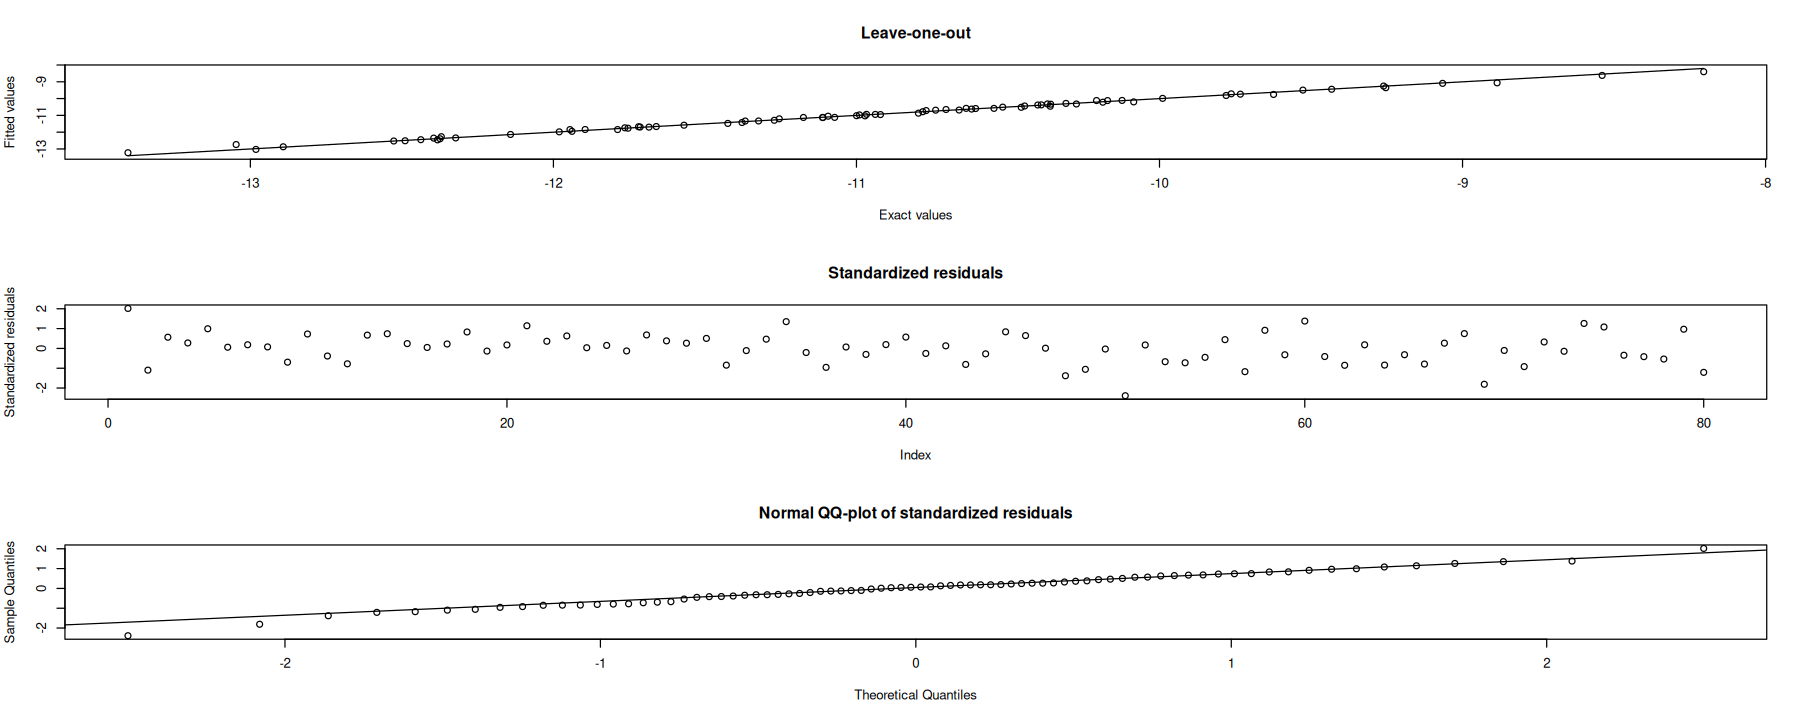

[1] 0.9955692


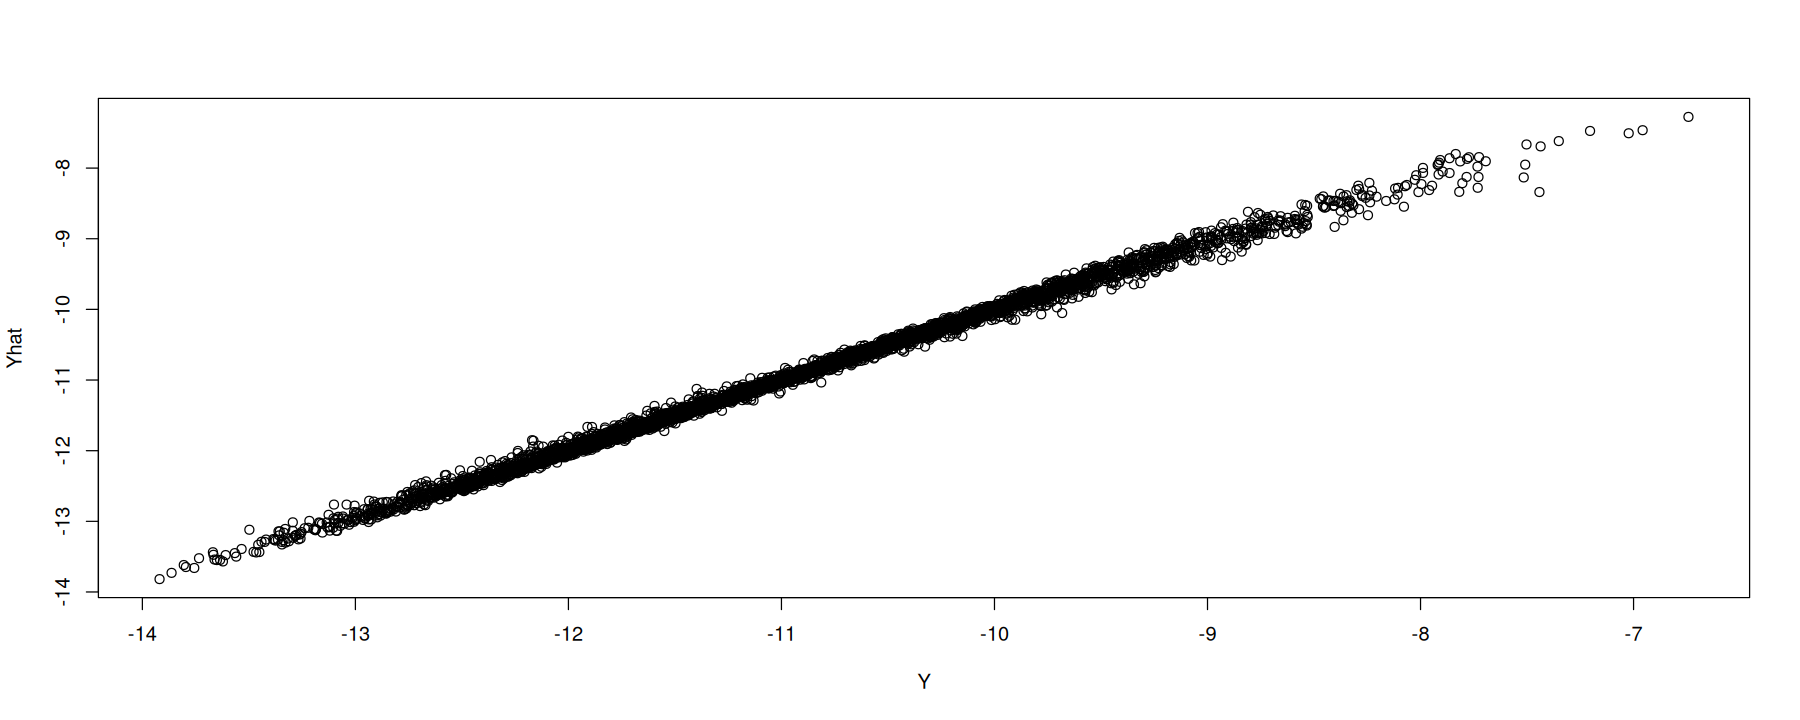

abline                package:graphics                 R Documentation

_A_d_d _S_t_r_a_i_g_h_t _L_i_n_e_s _t_o _a _P_l_o_t

_D_e_s_c_r_i_p_t_i_o_n:

     This function adds one or more straight lines through the current
     plot.

_U_s_a_g_e:

     abline(a = NULL, b = NULL, h = NULL, v = NULL, reg = NULL,
            coef = NULL, untf = FALSE, ...)
     
_A_r_g_u_m_e_n_t_s:

    a, b: the intercept and slope, single values.

    untf: logical asking whether to _untransform_.  See ‘Details’.

       h: the y-value(s) for horizontal line(s).

       v: the x-value(s) for vertical line(s).

    coef: a vector of length two giving the intercept and slope.

     reg: an object with a ‘coef’ method.  See ‘Details’.

     ...: graphical parameters such as ‘col’, ‘lty’ and ‘lwd’ (possibly
          as vectors: see ‘Details’) and ‘xpd’ and the line
          characteristics ‘lend’, ‘ljoin’ and ‘lmitre’.

_D_e_t_a_i_l_s:

     Typical usa

In [8]:
# help for question 5
library(DiceKriging)
# ?km

# For function km, a data.frame is required for argument design. Use:
train <- data.frame(Xtrain)
names(train) <- floodInputNames
test <- data.frame(X)
names(test) <- floodInputNames
# important : use multistart (possibility of parallel computations)
Ytrain <- flood(Xtrain, ans = myOutput)
kriging <- km(~1, design = train, response = Ytrain, multistart = 5)
Yhat <- predict.km(kriging, test, "UK")$mean
plot(kriging)
# a code for the Q2 criterion is the following
Q2 <- function(y, yhat) {
  1 - sum((y - yhat)^2) / sum((y - mean(y))^2)
}

# in the plot Yhat versus Y, add the straight line y = x:
?abline
plot(Y, Yhat)
print(Q2(Y, Yhat))

## Q6.
6. Compare the performance of the GP metamodel with a naive linear model (first-order polynomial). When the output is the cost, add $H_d^2$ to the covariates of this linear model (explain why it is reasonable). For that, plot the predictions versus the true values, and compute the $Q^2$ criterion as well.

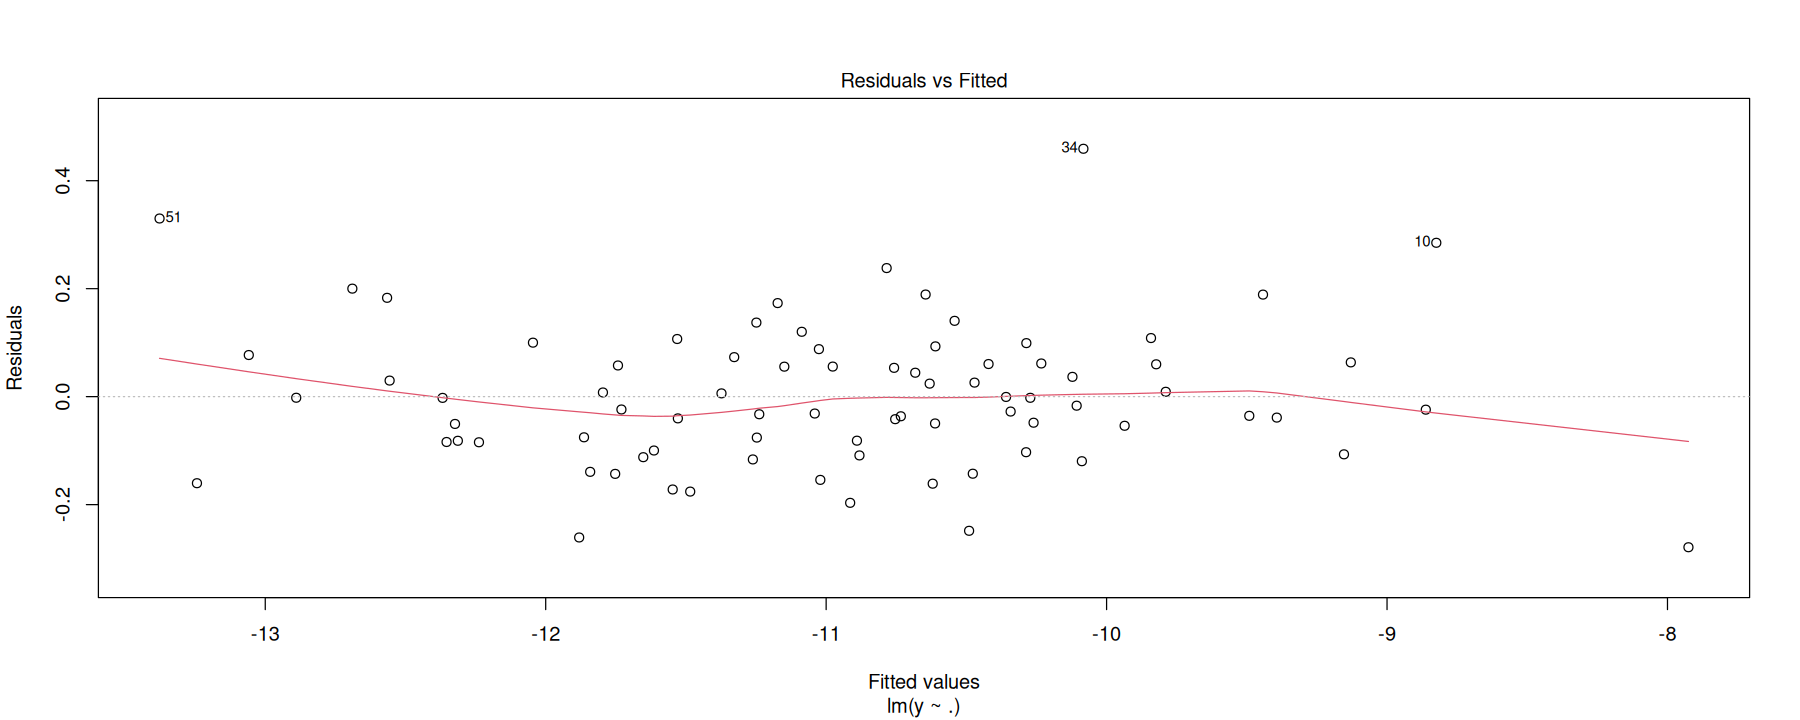

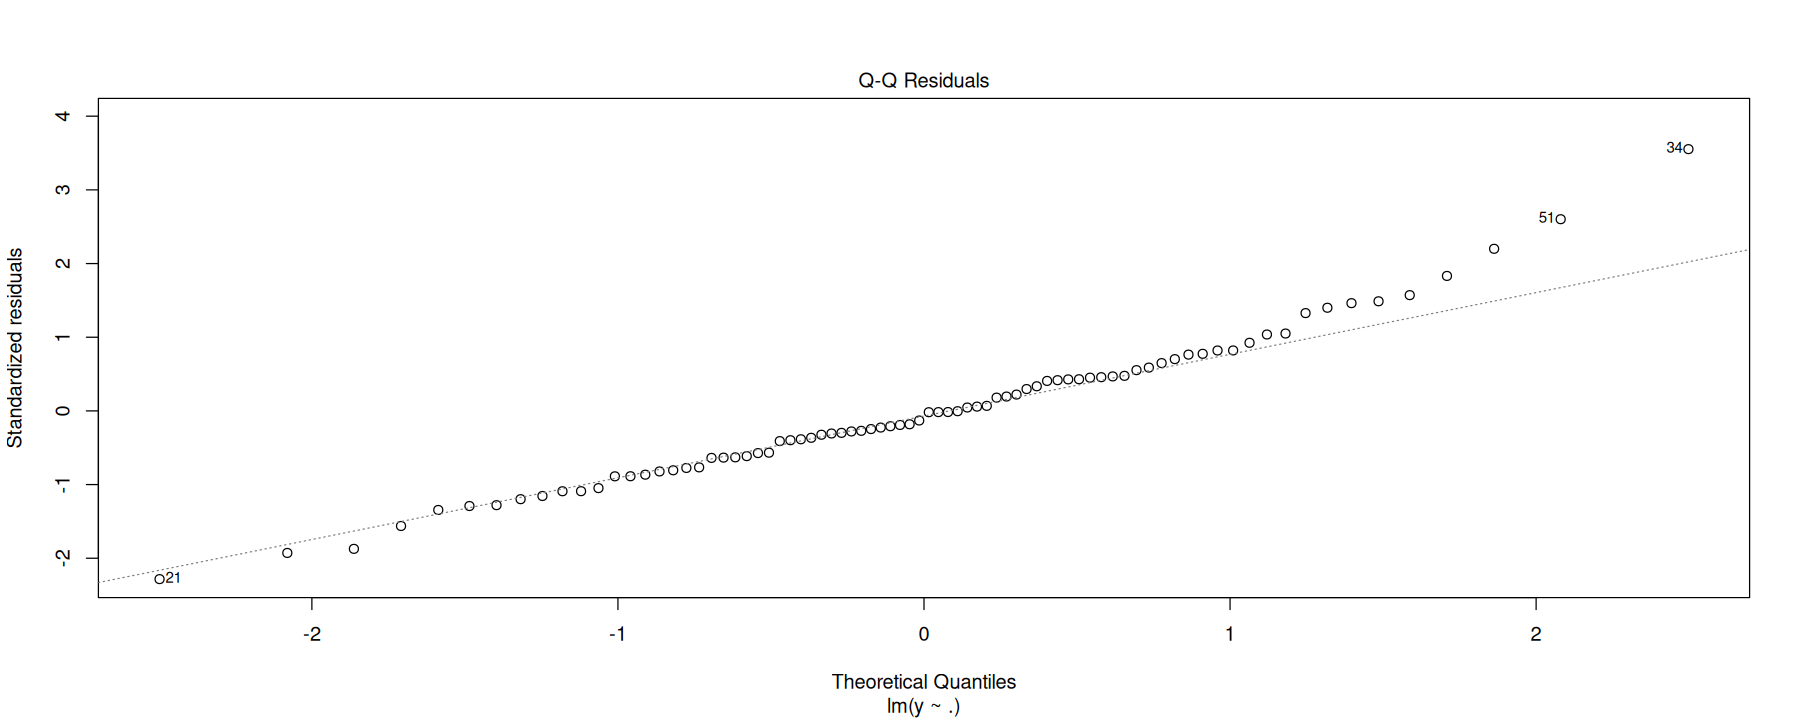

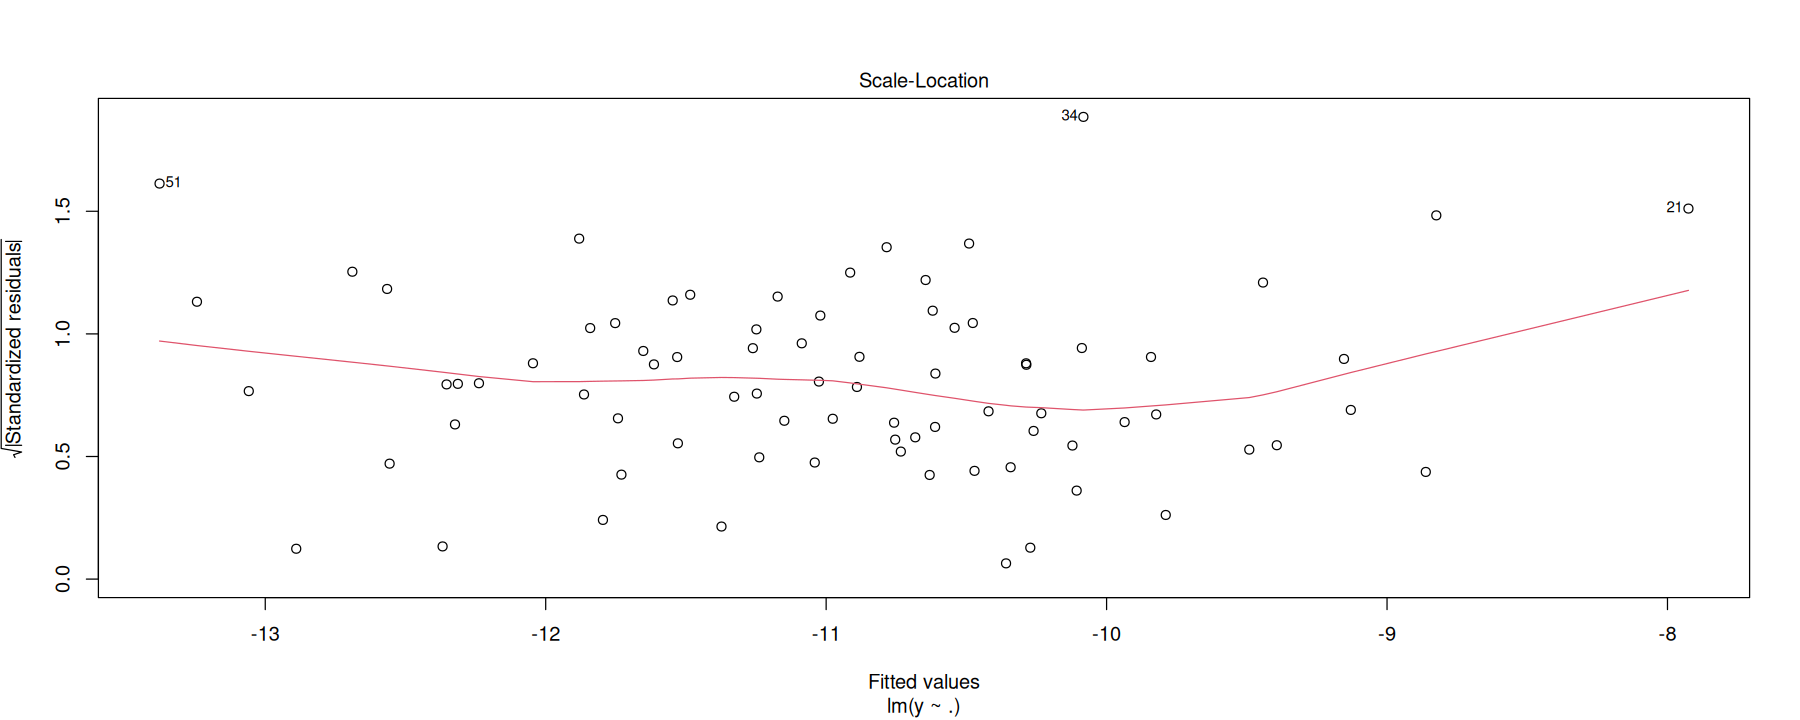

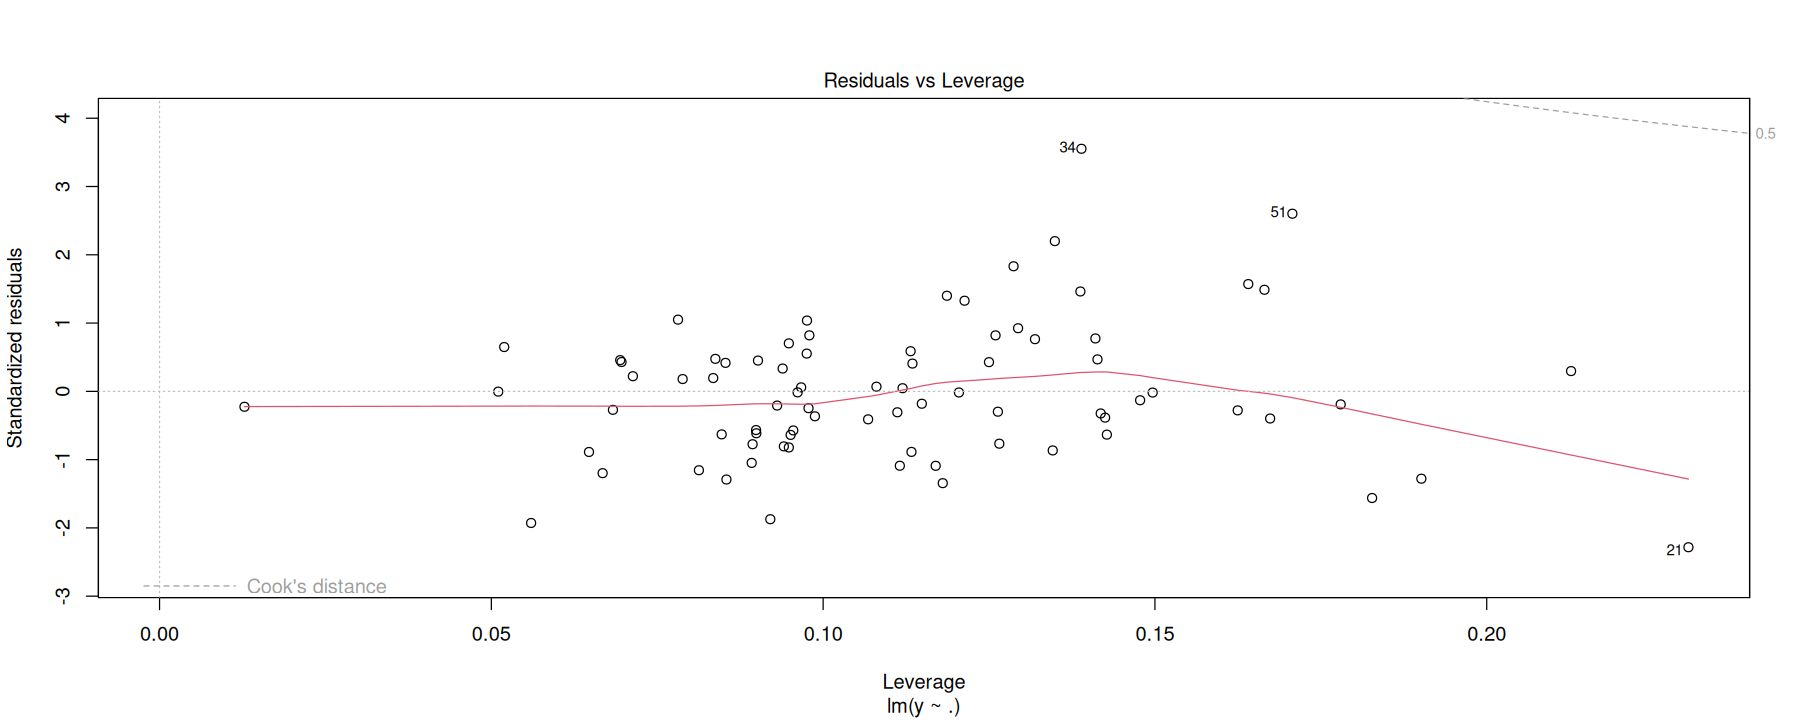

[1] 0.9780249

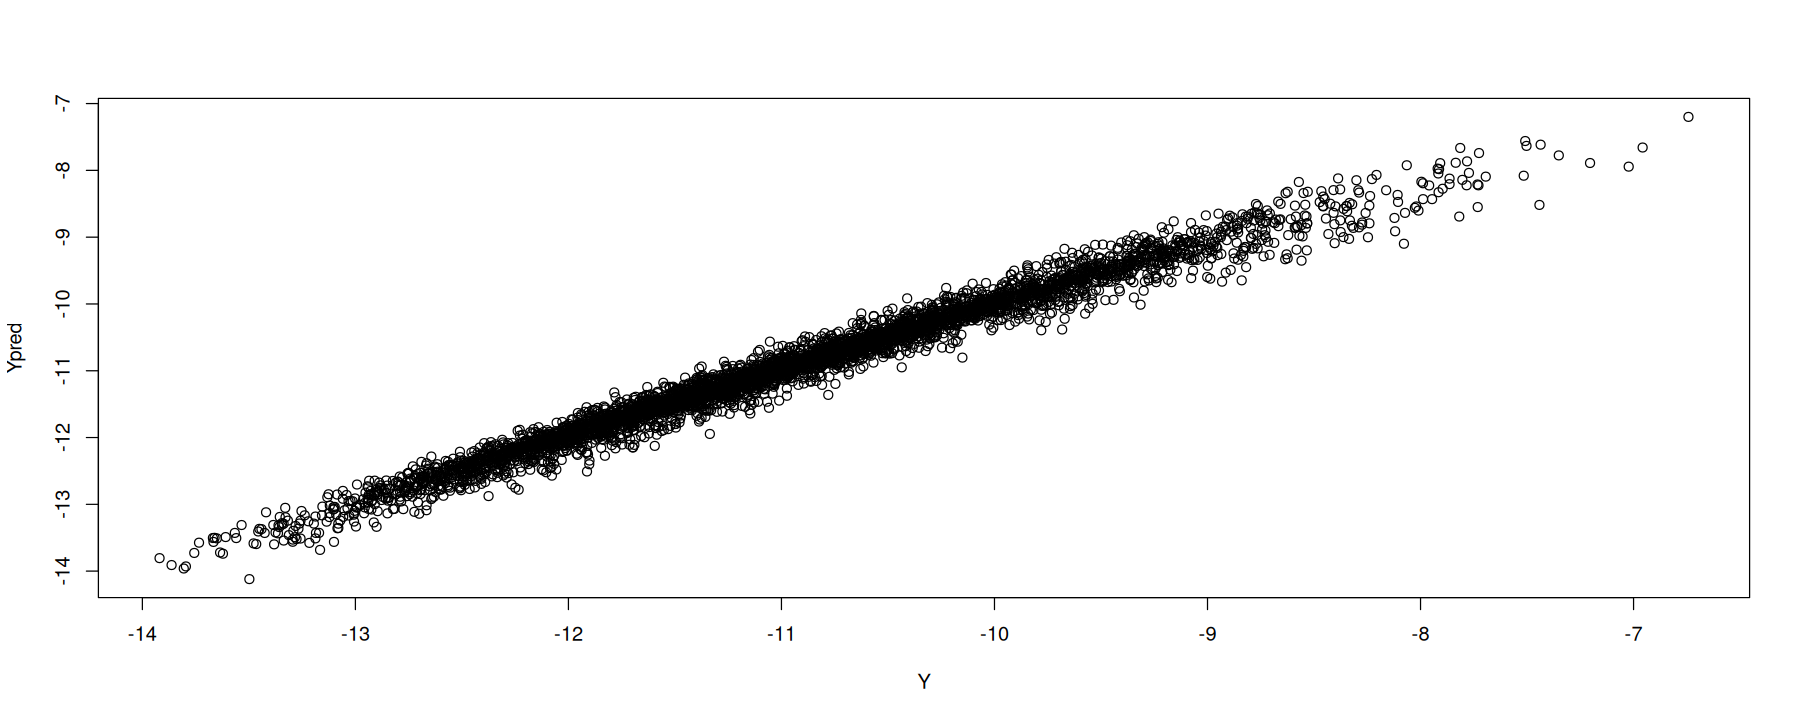

In [9]:
# Help for question 6
# ?lm
# Pour lm, it is recommended to use a data.frame pour data,
# containing both Xtrain (train more precisely, cf. question 5) and Ytrain
data <- data.frame(y = Ytrain, train)
lm0 <- lm(y ~ ., data = data)
# for prediction on a new dataset, both lm and km want data.frame
# with the SAME input names as Xtrain (and not only matrices).
# Thus, use
newdata <- data.frame(X)
names(newdata) <- floodInputNames
Ypred <- predict.lm(lm0, newdata)
plot(lm0)
plot(Y, Ypred)
Q2(Y, Ypred)


The performance of the linear model is comparable to that of the kriging model, the value of $Q^2 = 97.78\%$ is a little lower, which is expected because the kriging model can approximate non-linear dependencies.

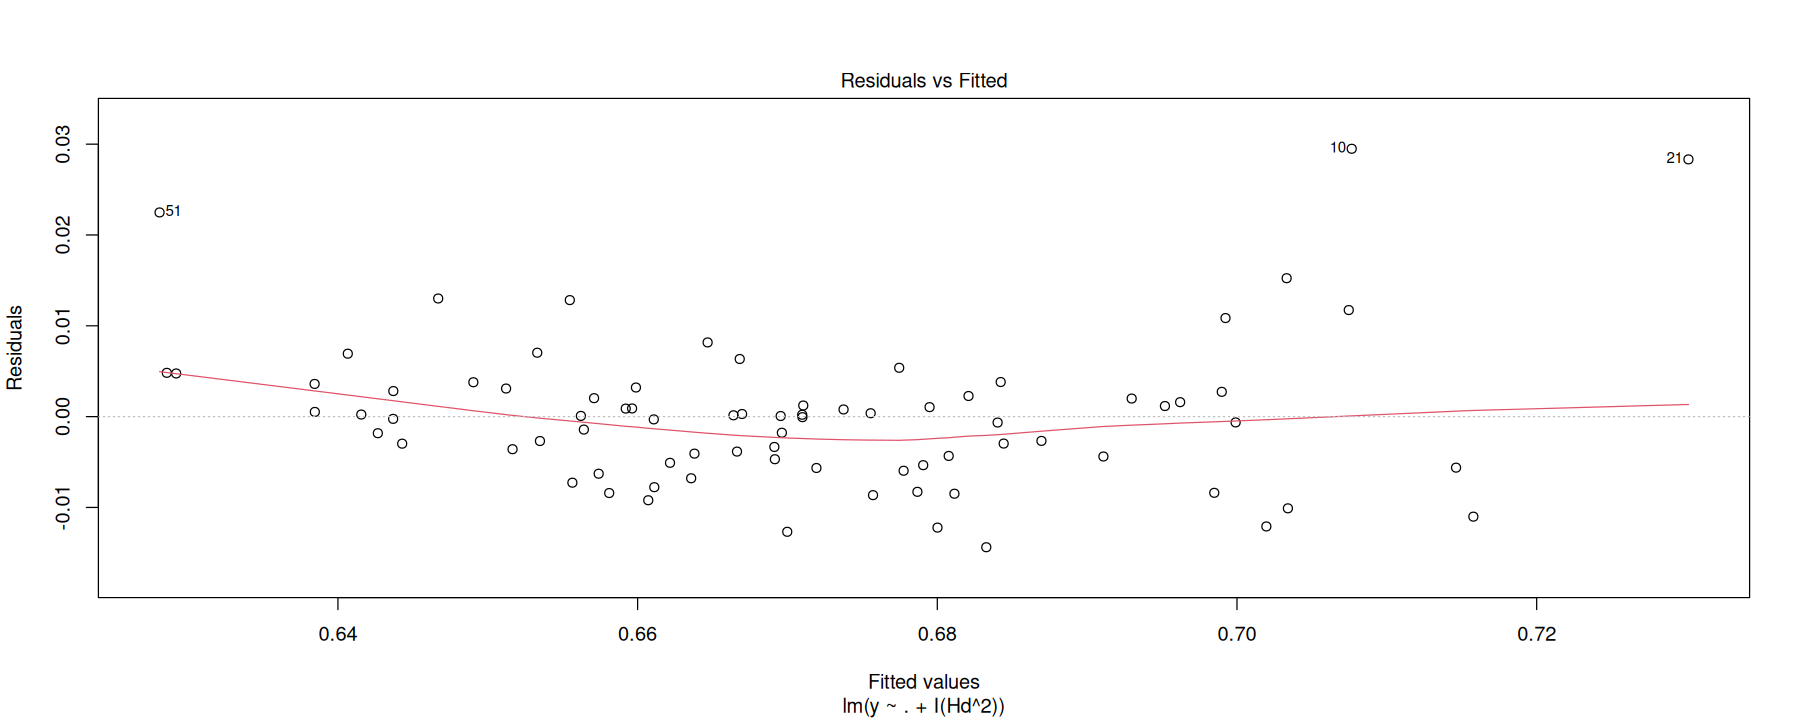

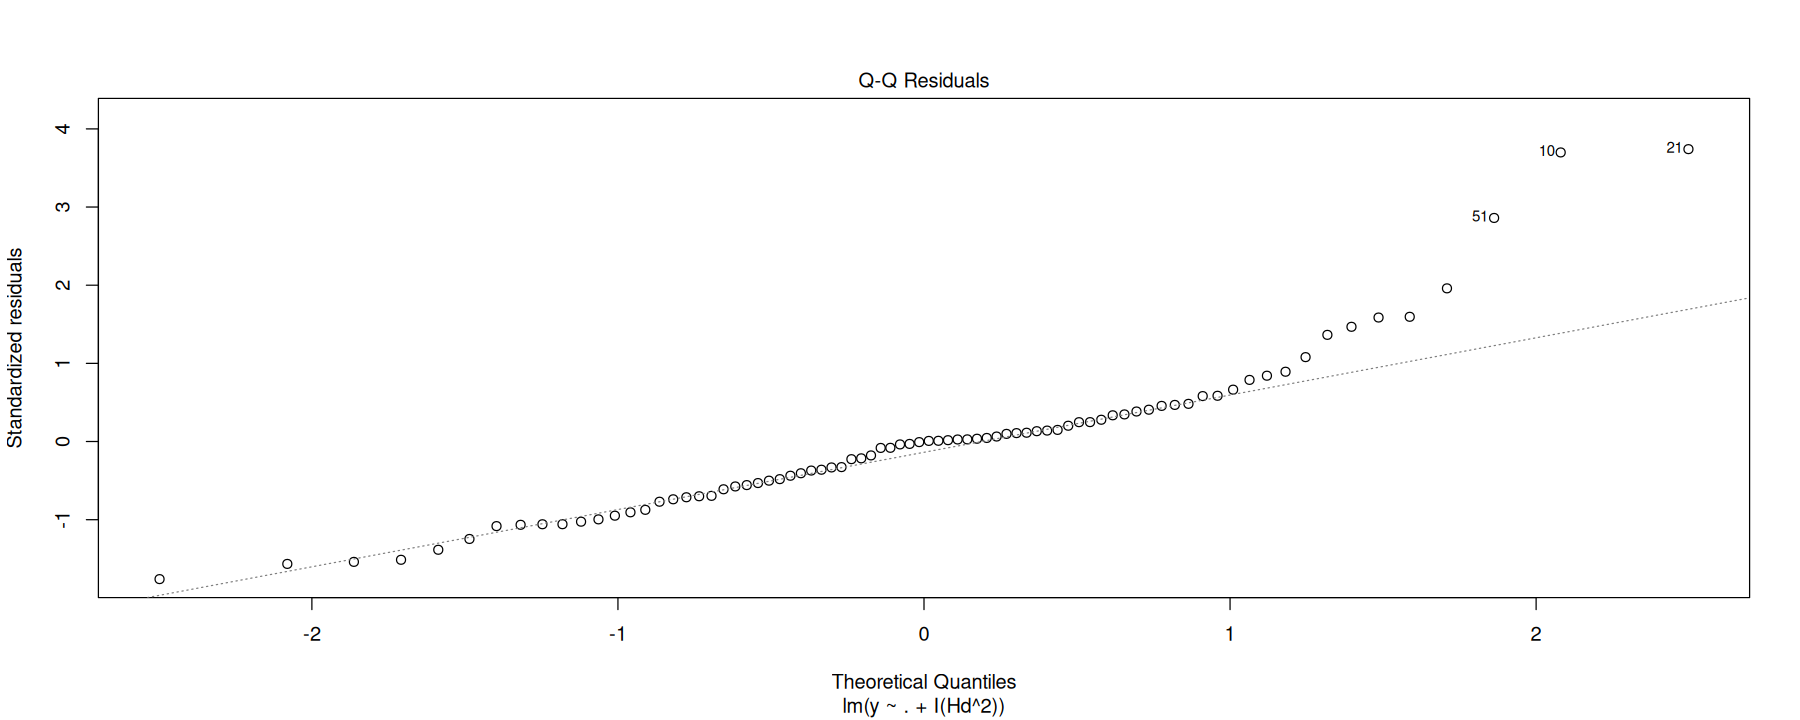

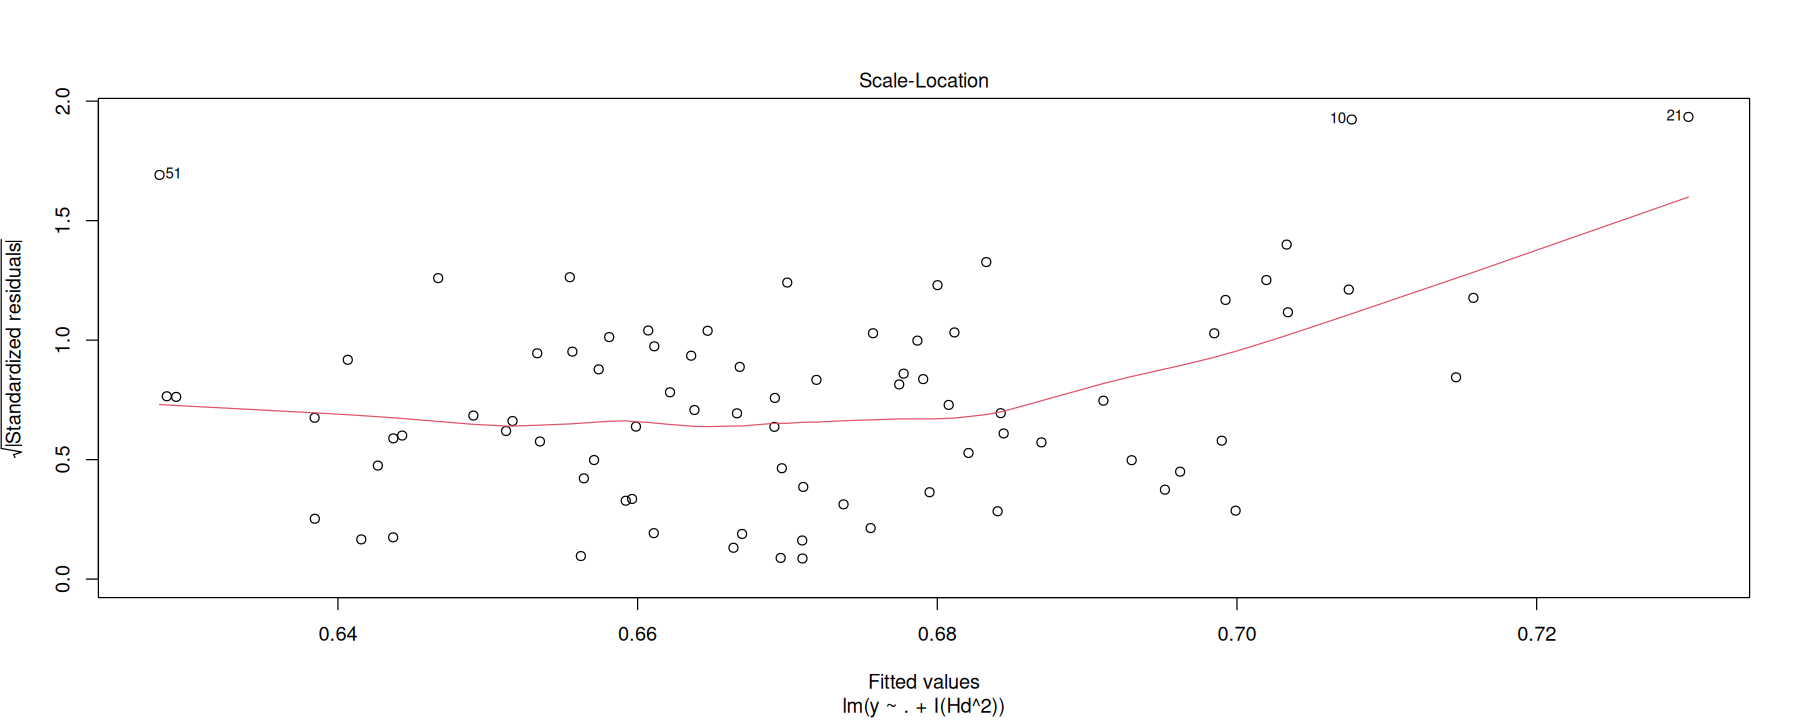

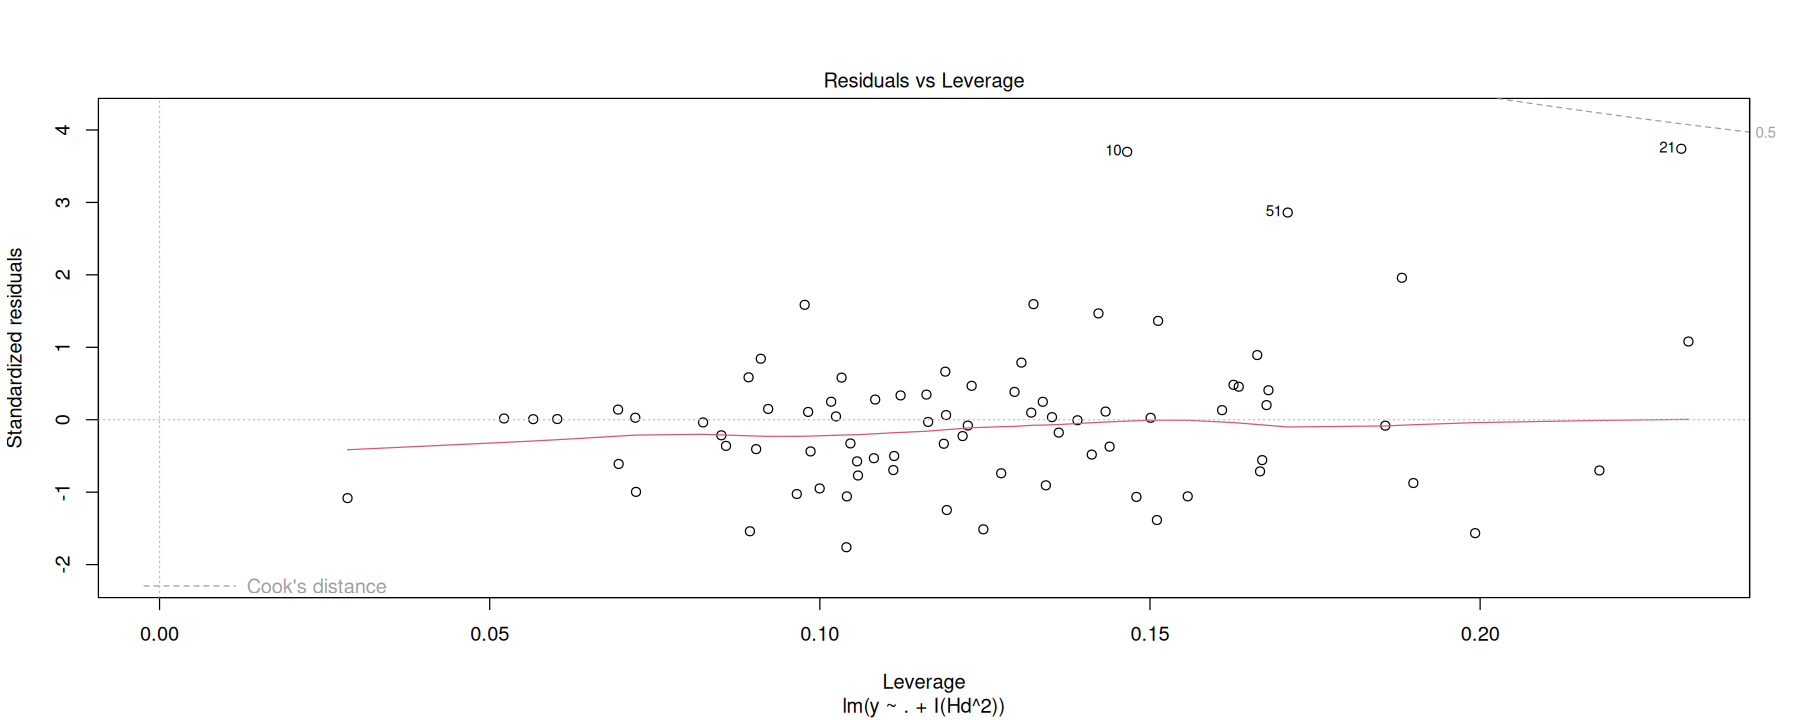

[1] 0.7928205

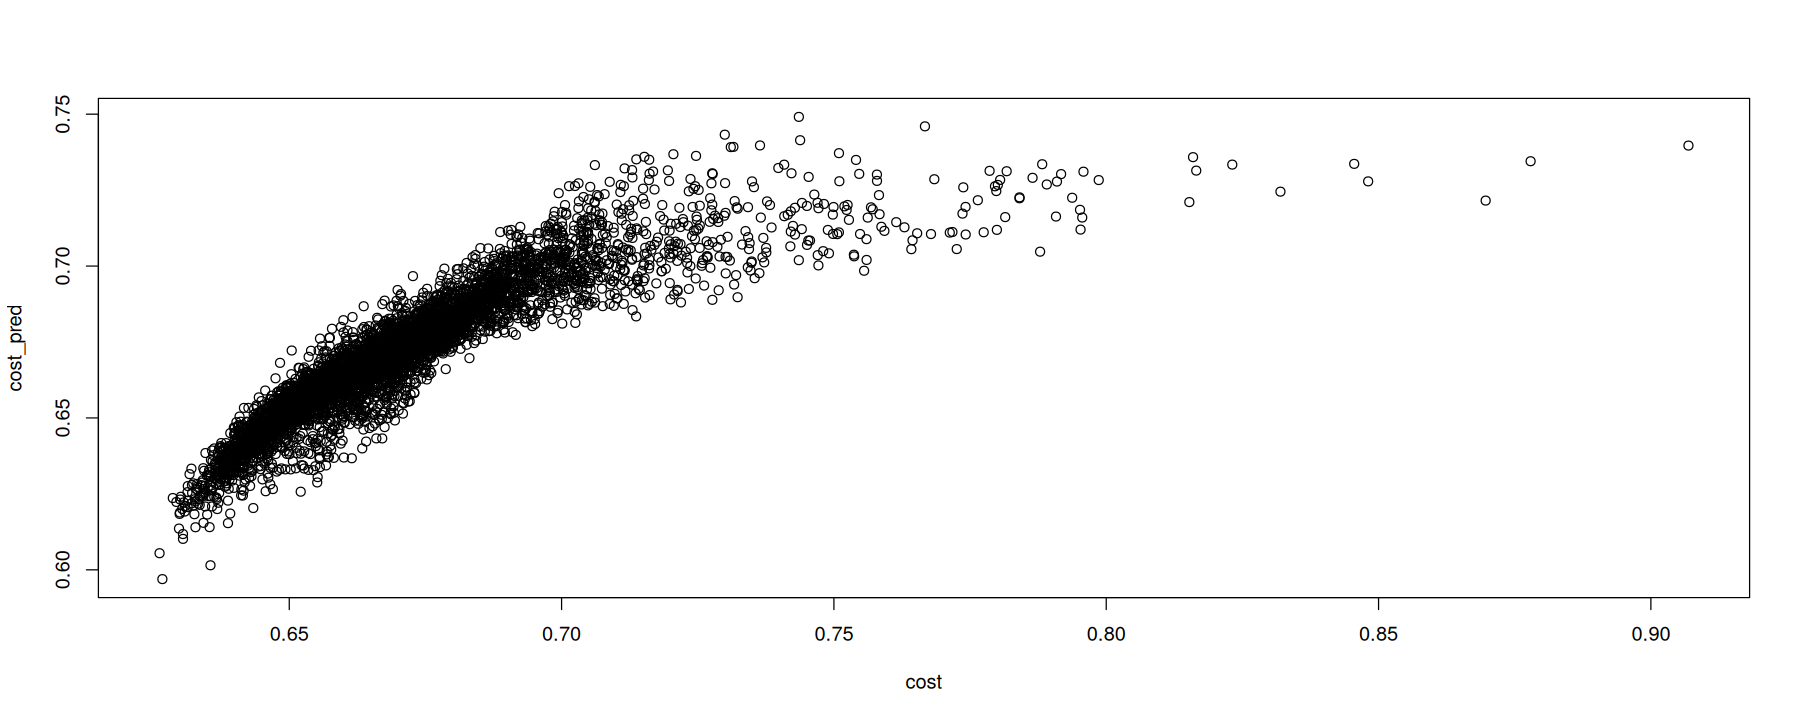

In [10]:
myOutput <- 2
cost <- flood(X, myOutput)
cost_train <- flood(Xtrain, myOutput)
cost_data <- data.frame(y = cost_train, train)
lm1 <- lm(y ~ . + I(Hd^2), data = cost_data)
cost_pred <- predict.lm(lm1, newdata)
plot(lm1)
plot(cost, cost_pred)
Q2(cost, cost_pred)

It is reasonable to use $H_d ^2$ as a variable in the model because in the formula to compute the cost there is a term in $H$ that is equal to $\frac{1}{20}\left(H_d 1_{H_d>8} + 8 1_{H_d \leq 8} \right)$. This term is not linear with respect to $H_d$ which means that we should aproximate it with a higher order function, in this case a 2nd degree polynomial function.

## Q7.
7. Perform a GSA on the mean of the GP metamodel (kriging mean) by doing questions 1-3 for it. Compare these results to the unlimited budget case.

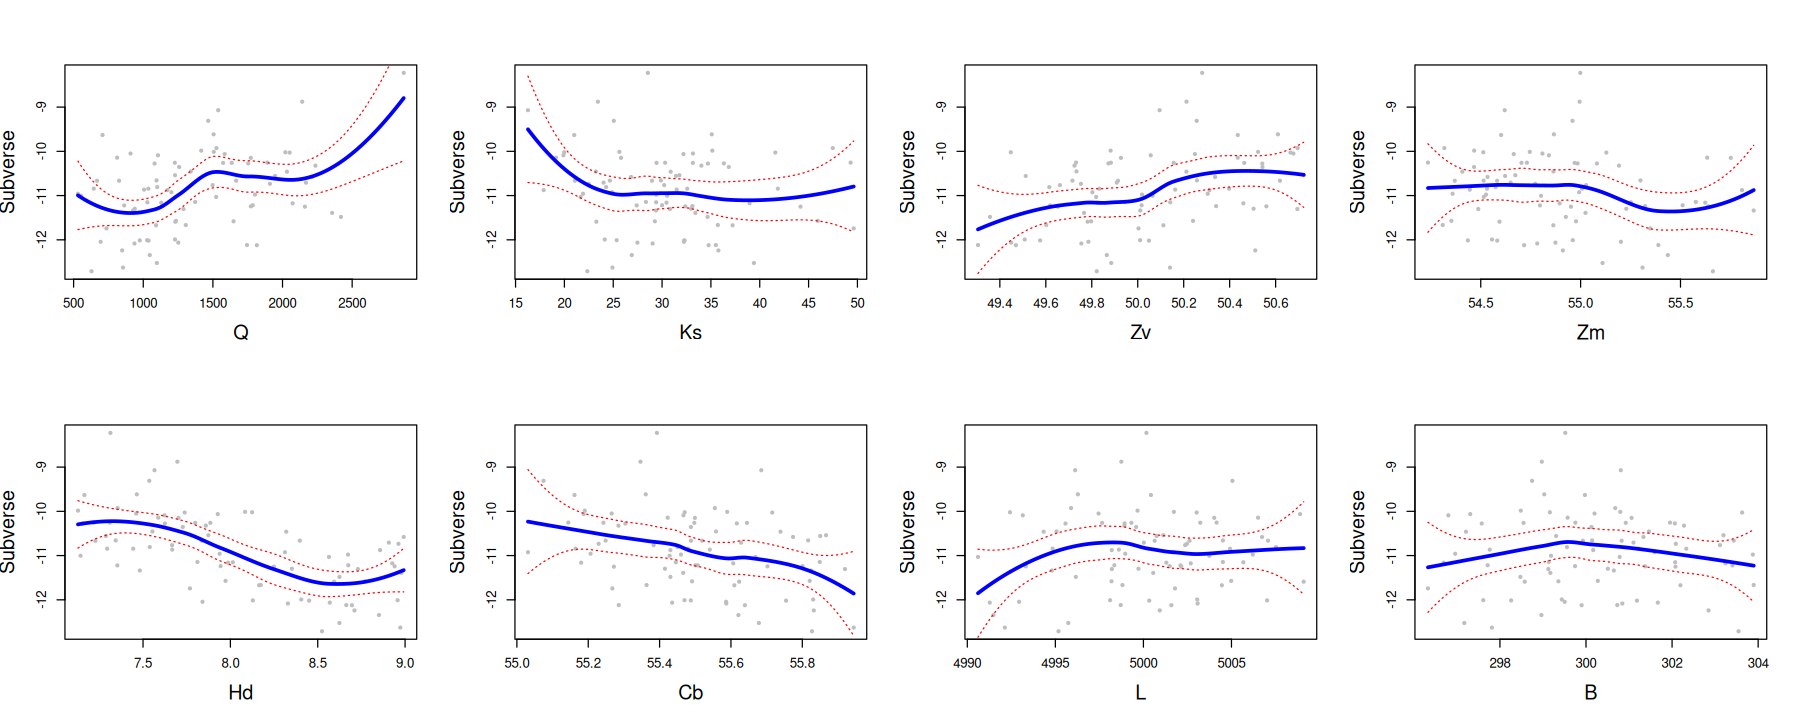

In [11]:
# help for question 7

# to plot the main effects, it can be useful to add the confidence intervals, because n is small.
# here is the code of question 2, for n = 80, with confidence intervals. To be adapted to your purpose !!
myOutput <- 1
n <- 80
set.seed(0)
X <- floodSample(n)
colnames(X) <- floodInputNames
Y <- flood(X, ans = myOutput)

par(mfrow = c(2, 4))
for (i in 1:8) {
  plot(Y ~ X[, i],
    xlab = floodInputNames[i], ylab = floodOutputNames[myOutput],
    pch = 19, col = "grey", cex = 0.5, cex.lab = 1.5
  )
  ss <- loess(Y ~ X[, i], se = TRUE)
  t <- seq(from = min(X[, i]), to = max(X[, i]), length = 100)
  predss <- predict(ss, t, se = TRUE)
  lines(t, predss$fit, col = "blue", lwd = 3)
  lines(t, predss$fit + 2 * predss$se, col = "red", lty = "dotted")
  lines(t, predss$fit - 2 * predss$se, col = "red", lty = "dotted")
}

# Use the following wraper, where m is the ouput of function km: m <- km(...), and Xnew is a test set.
krigingMean <- function(Xnew, m) {
  pred <- predict(m, Xnew, "UK", se.compute = FALSE, checkNames = FALSE)
  return(as.numeric(pred$mean))
}


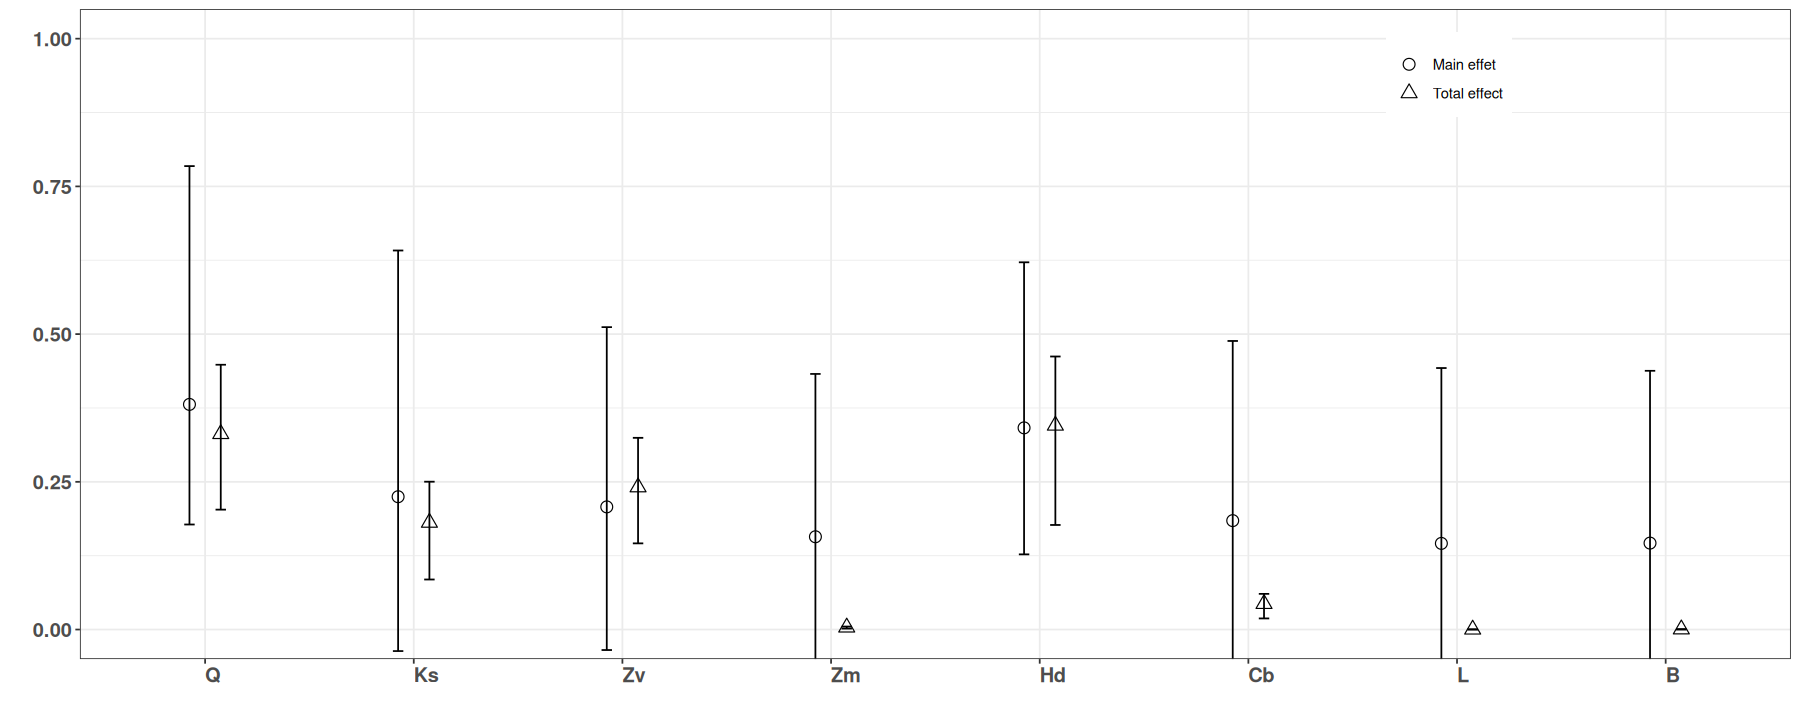

In [12]:
X1 <- floodSample(n)
X2 <- floodSample(n)
X1 <- data.frame(X1); names(X1) <- floodInputNames
X2 <- data.frame(X2); names(X2) <- floodInputNames

# sensitivity analysis
SAresult <- soboljansen(model = krigingMean, X1, X2, nboot = 100, m = kriging)
totalIndex <- SAresult$T$original
names(totalIndex) <- floodInputNames
sobolIndex <- SAresult$S$original
names(sobolIndex) <- floodInputNames

library(ggplot2)
ggplot(SAresult)


We notice that there is a lot more uncertainty in the evaluation of both the main and total effects of each variable, which is expected because of the lower number of samples used. If we had kept $N = 5000$ we would be more accurate and get the same result as the first GSA plot.\
Also the main effects found using 80 points no longer look linear.

## Q8.
8. Consider the output "subverse". Play with function 'km' in order to add a linear trend to the GP model. Check that this model outperforms the basic GP, by plotting the prediction on the test set (here $X$) versus the true value, and computing the $Q^2$ criterion. Redo question 7 for this model. Comment


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~Q + Ks + Zv + Zm + Hd + Cb + L + B
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  4677.816 66.69665 2.834712 3.261671 3.7291 1.826015 36.99122 15.1373 
  - best initial criterion value(s) :  68.98875 63.49805 62.0023 61.89752 56.84023 

N = 8, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -68.989  |proj g|=       1.7654
At iterate     1  f =      -79.757  |proj g|=       0.63122
At iterate     2  f =      -79.983  |proj g|=       0.58663
At iterate     3  f =      -81.567  |proj g|=       0.61278
At iterate     4  f =      -82.116  |proj g|=       0.30683
At iterate     5  f =      -83.352  |proj g|=        0.3021
At iterate     6  f =      -86.907  |proj g|= 

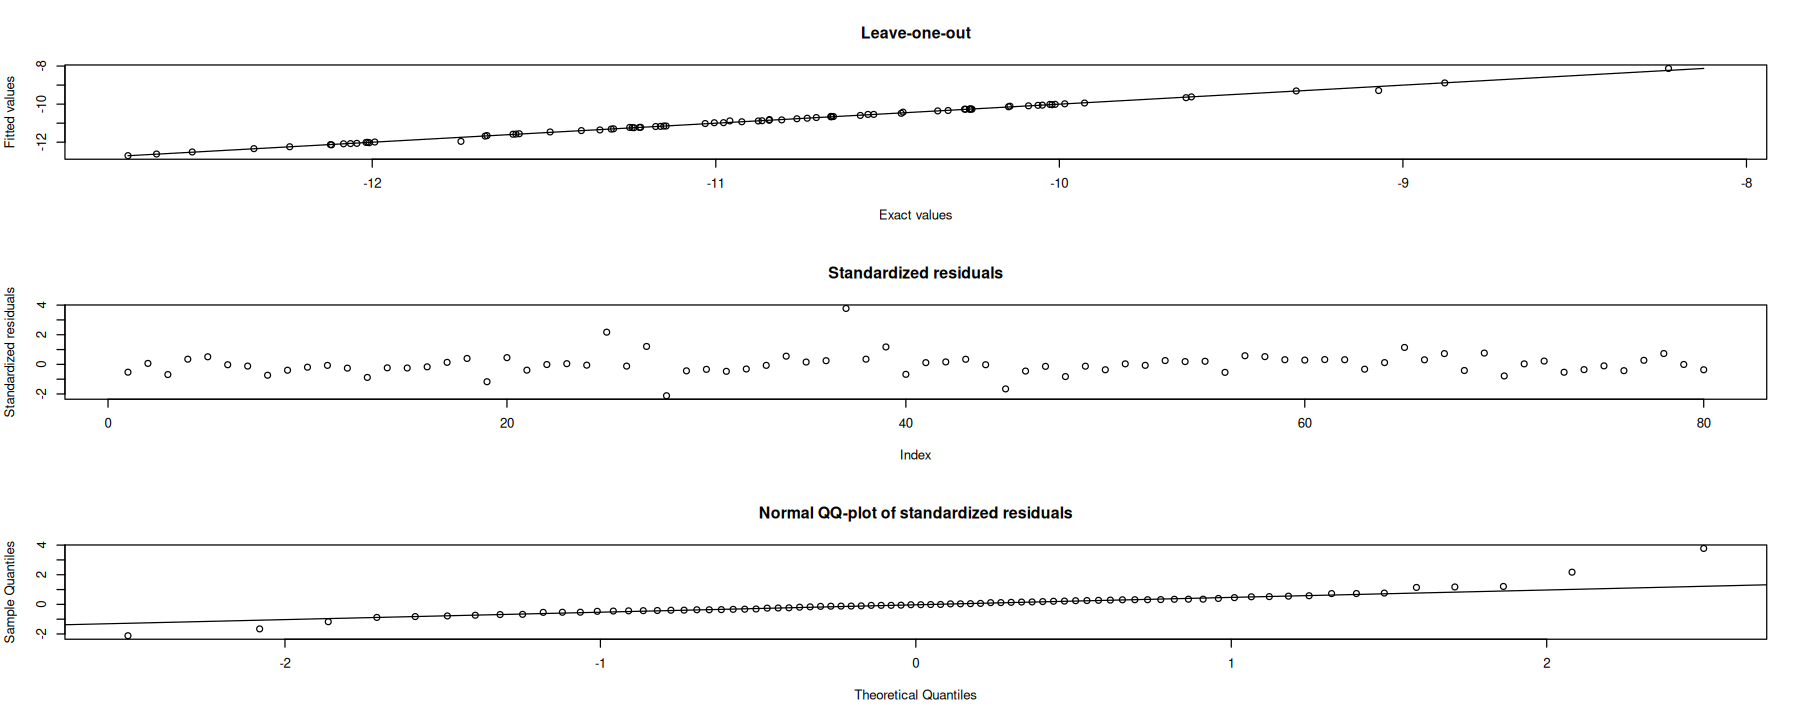

[1] 0.9987671

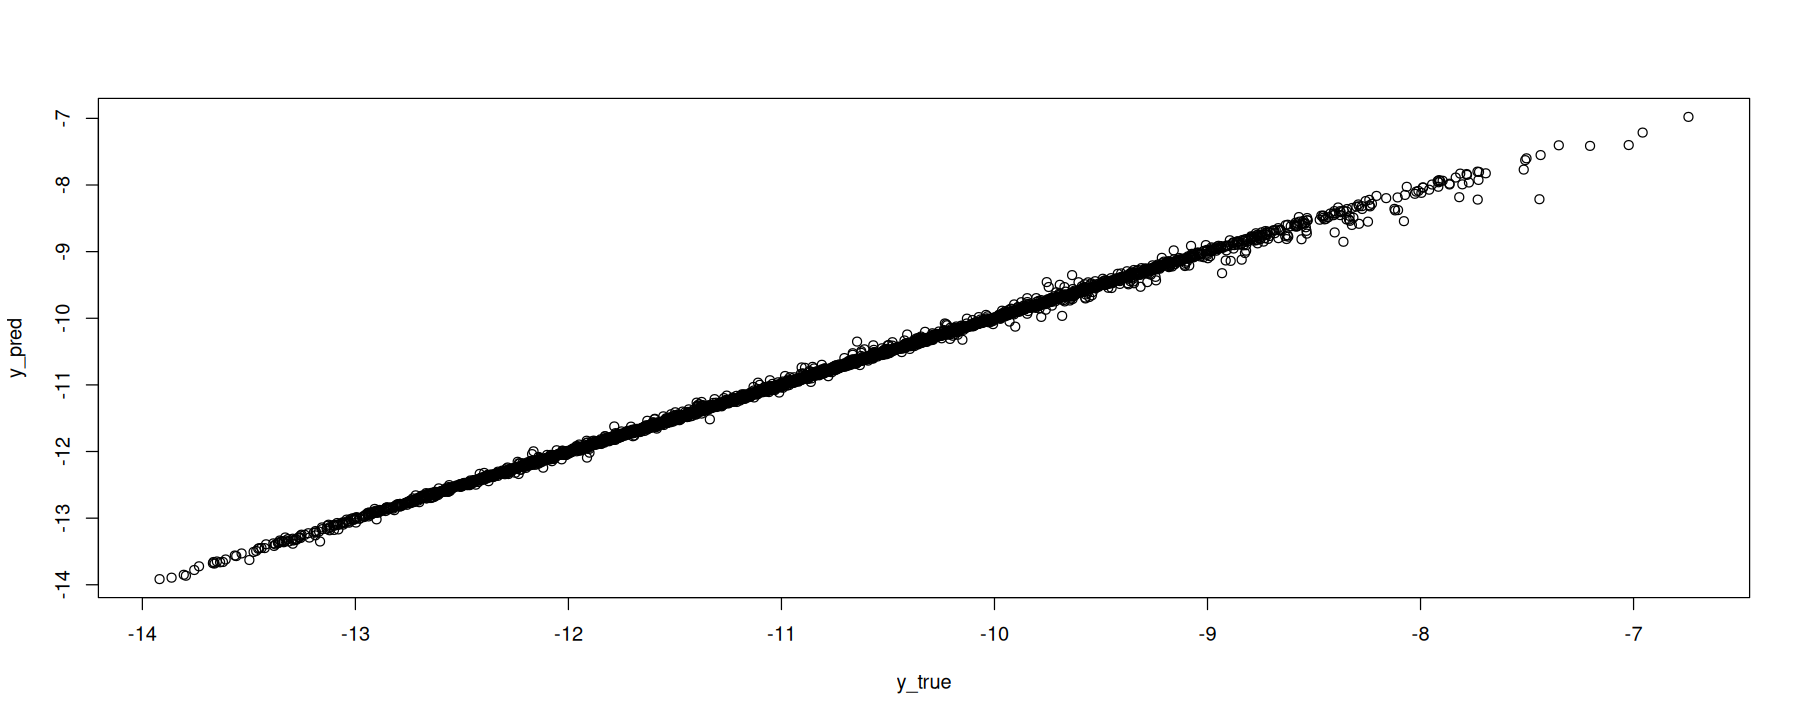

In [13]:
kriging2 <- km(~ ., design = X, response = Y, multistart = 5)
y_pred <- predict.km(kriging2, test, "UK")$mean
y_true <- flood(test, myOutput)
plot(kriging2)
plot(y_true, y_pred)
Q2(y_true, y_pred)

We obtain a kriging model that outperforms the first one, with a $Q^2$ value of $99.88\%$, the standardized residuals as well the normal QQ-plot also show that this model fits the data better. Finally, when we plot the predicted data against the true values, we see less noise (the line is thinner).

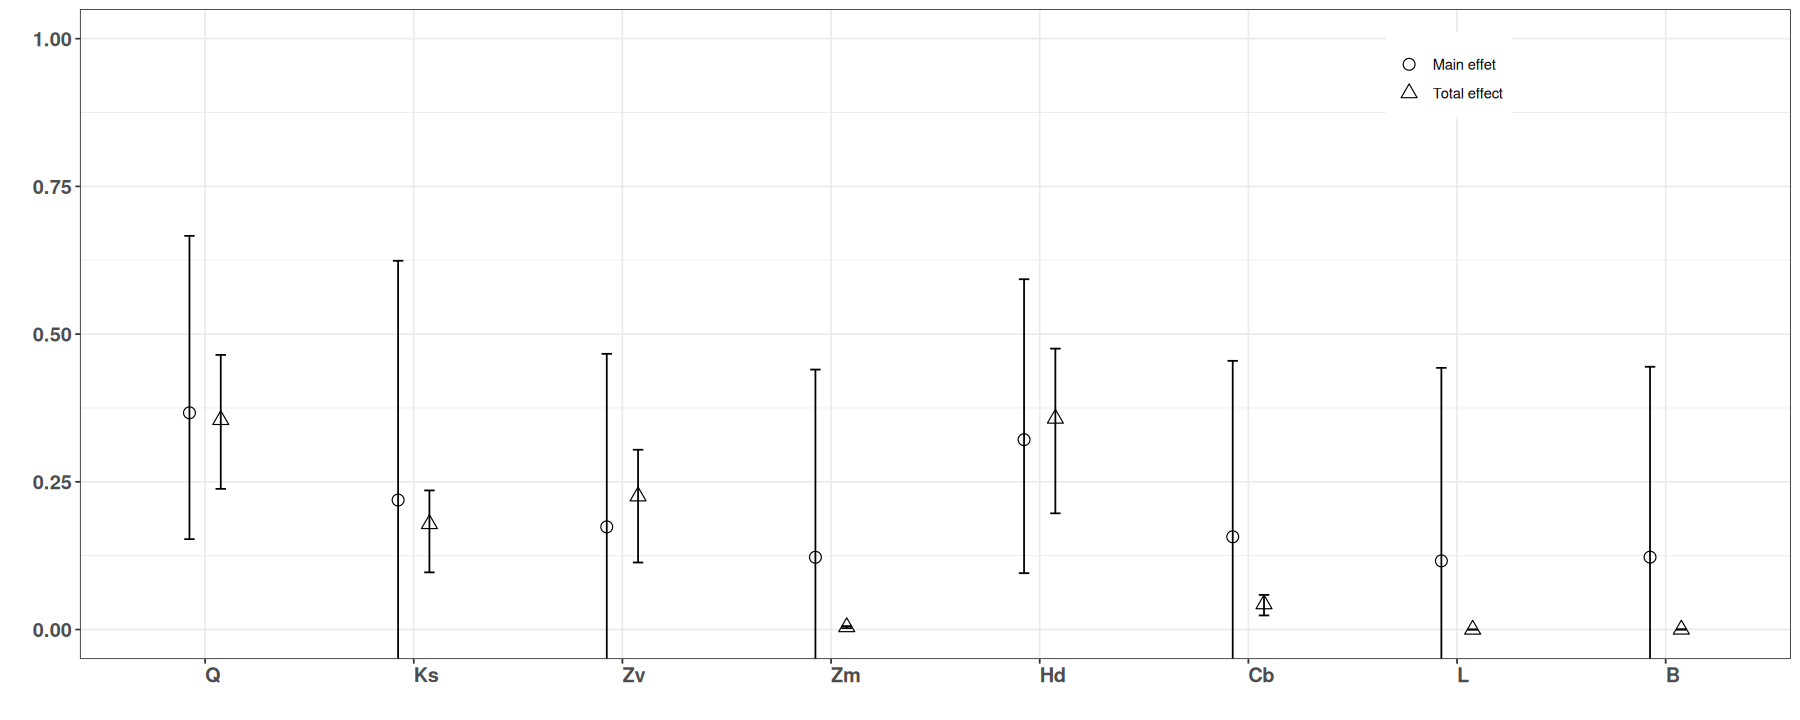

In [14]:
SAresult <- soboljansen(model = krigingMean, X1, X2, nboot = 100, m = kriging2)
totalIndex <- SAresult$T$original
names(totalIndex) <- floodInputNames
sobolIndex <- SAresult$S$original
names(sobolIndex) <- floodInputNames

library(ggplot2)
ggplot(SAresult)

This new GSA also looks like the one produced by the first kriging model, which validates its results.

## Q9.

9. Knowing the equation of the ouput "cost", we see that a suitable GP should have the form 
$$Y(S, H_d) = Y_1(S) + Y_2(H_d)$$
Assuming that $Y_1, Y_2$ are independent Gaussian processes with kernels $k_1, k_2$, what form should have the kernel of $Y$? Estimate this new GP with function "kmAdditive", from the R package fanovaGraph, still using $Xtrain$ as a desing of experiments. Check that this model outperforms the basic GP. Compare also with a GP depending on $S$ and $H_d$. However, explain why it seems difficult to use this approach for global sensitivity analysis with respect to the original variables.

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union





optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  4469.454 61.69289 3.396447 3.396447 3.875 1.698223 32.92893 16.98223 
  - best initial criterion value(s) :  261.5069 251.5911 248.3934 240.4894 238.4535 

N = 8, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -261.51  |proj g|=       2.1121
At iterate     1  f =      -267.69  |proj g|=        1.8813
At iterate     2  f =      -272.49  |proj g|=        2.3349
At iterate     3  f =      -276.01  |proj g|=        1.6349
At iterate     4  f =      -279.62  |proj g|=         2.282
At iterate     5  f =      -280.33  |proj g|=         1.277
At iterate     6  f =      -280.48  |proj g|=       0.79933
At iterate     7  

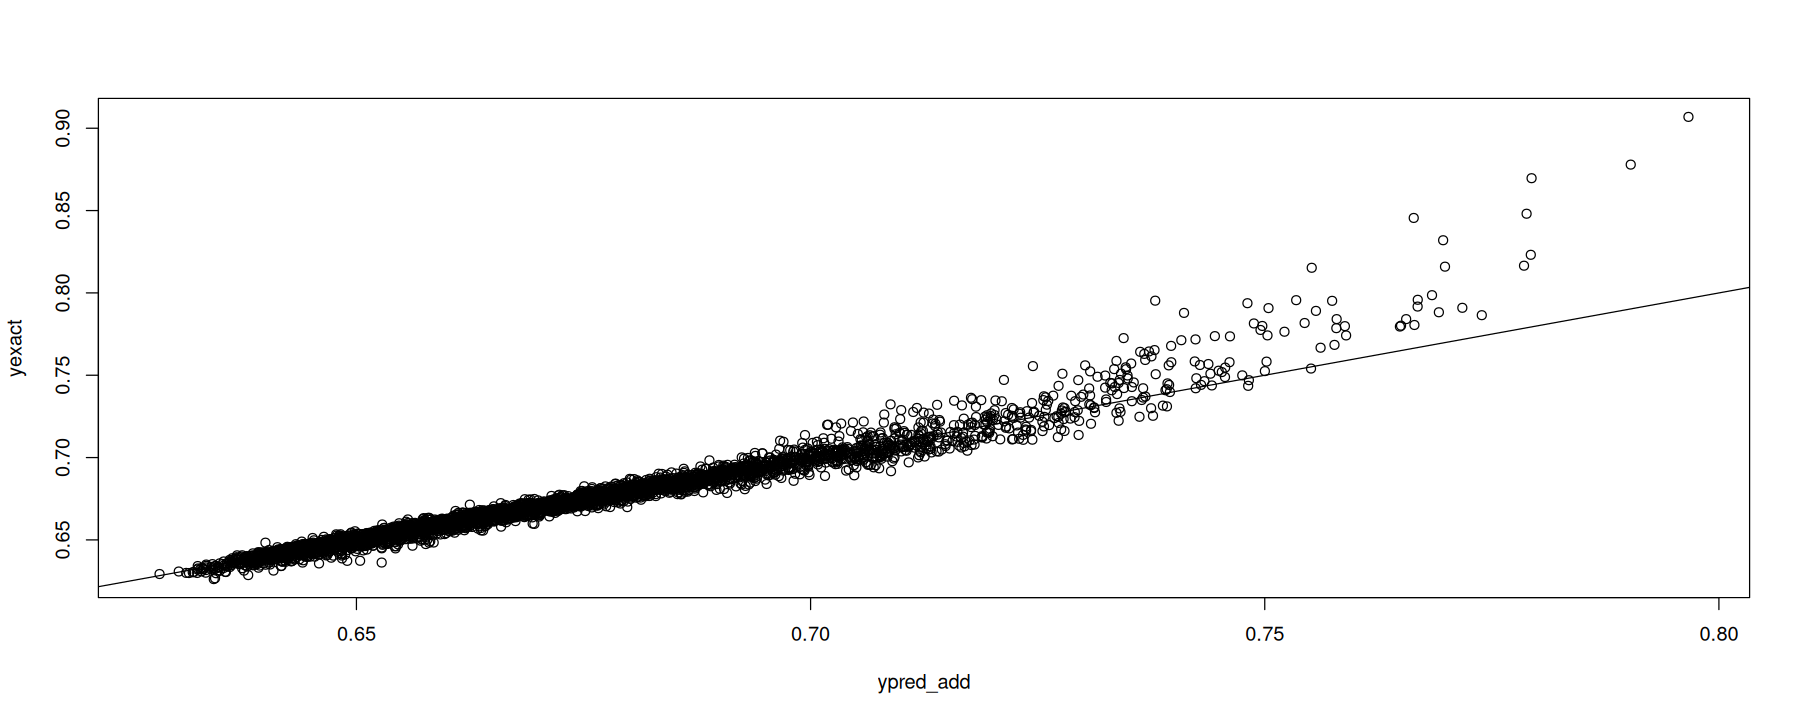

kmAdditive             package:fanovaGraph             R Documentation

_C_o_n_s_t_r_a_i_n_e_d _M_L_E _O_p_t_i_m_i_z_a_t_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     Constrained MLE optimization for kernels defined by cliques using
     ‘constrOptim’

_U_s_a_g_e:

     kmAdditive(x, y, n.initial.tries = 50, limits = NULL, eps.R = 1e-08, cl, 
     covtype = "gauss", eps.Var = 1e-06, max.it = 1000, iso = FALSE)
     
_A_r_g_u_m_e_n_t_s:

       x: a design matrix of input variables, number of columns should
          be number of variables

       y: a vector of output variables of the same length as the
          columns of ‘x’

n.initial.tries: number of random initial parameters for optimization,
          defaults to 50

  limits: a list with items lower, upper containing boundaries for the
          covariance parameter vector theta, if ‘NULL’ suitable bounds
          are computed from the range of ‘x’

   eps.R: small positive number indi

In [16]:
# help for question 9
library(fanovaGraph)
?kmAdditive
# A clique is a complete subgraph, i.e. where all vertices are connected.
# Here the vertices [sommets] are variables; an edge [arêtes] exists if there is an interaction 
# involving at least the two variables corresponding to two vertices.
# Thus a clique correspond to a group of variables that interact together and, more importantly, 
# variables belonging to different cliques should not have any interaction at any order (alone or with other variables).
# In brief, if a function is additive with respect to groups of variables, the cliques correspond to the groups.
# For instance, in the Ishigami function, there are two cliques : {1, 3} and {2}.

# Similarly to question 7, here is a wraper for sensitivity analysis
krigingMeanAdditive <- function(newdata, design, response, gp, cliques){
    predictAdditive(newdata = newdata, x = design, y = response, parameter = gp, cl = cliques)$mean
}

myOutput <- 2
Ytrain <- flood(Xtrain,myOutput)
n <- 5000  
set.seed(0); X <- floodSample(n); colnames(X) <- floodInputNames
test <- data.frame(X)
names(test) <- floodInputNames

cl <- list(c(1,2,3,4,5,6,7,8), c(5))
# train model
parameter <- kmAdditive(train, Ytrain, cl=cl)
# prediction with the new model
ypred_add <- krigingMeanAdditive(test, train, Ytrain, parameter,cl)
yexact <- flood(test,myOutput)

kriging <- km(~1, design = train, response = Ytrain,multistart = 5) # model kriging
ypred <- predict(kriging, test, "UK")$mean # prediction

plot(ypred_add,yexact)
abline(0,1)
print(Q2(yexact,ypred_add))
print(Q2(yexact,ypred))

By using the `KmAdditive` function when isolating the 5th variable $H_d$, we get a better $Q^2$ score than the basic GP model.

In [17]:
#Only S and Hd
df_train <- as.data.frame(train$Hd)
colnames(df_train)[1] <- "Hd"
df_train$S <- flood(Xtrain,1)
kriging2 <- km(~1, design = df_train, response = Ytrain) # model kriging

#Predict S
S_train <- flood(Xtrain,1)
krigingS <- km(~1, design = train, response = S_train)
S_pred <- predict(krigingS, test, "UK")$mean

df_test <- data.frame(test$Hd)
colnames(df_test)[1] <- "Hd"
df_test$S <- S_pred

ypred <- predict(kriging2, df_test, "UK")$mean # prediction
print(Q2(yexact,ypred))


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  3.875 10.39941 
  - best initial criterion value(s) :  444.2259 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -444.23  |proj g|=       1.0231
At iterate     1  f =       -444.5  |proj g|=       0.67449
At iterate     2  f =      -444.51  |proj g|=       0.77339
At iterate     3  f =      -444.53  |proj g|=        1.6009
At iterate     4  f =      -444.61  |proj g|=        2.9346
At iterate     5  f =       -444.8  |proj g|=        2.9423
At iterate     6  f =      -445.24  |proj g|=        2.9324
At iterate     7  f =      -445.51  |proj g|=        2.9113
At iterate     8  f =       -445.9  |proj g|=        2.0025
At iterate     9  f =   

After predicting the values of $S$ using a GP model and using these predictions along with $H_d$ values we get an even better $Q^2$ value. This is an expected behaviour because we take into account the complexity of computing $S$ while training our model. The difficulty of computing Sobol indices is a direct consequence of regrouping the effects of all other variables in $S$, the model now only has information about $S$ and $H_d$.

## Q10.

10. For the output "S", compute theoretically the main effect with respect to the variable $H_d$. Compare with 3)a). Same question for $C_b$.

- The main effect of $H_d$. Thanks to the independence of the variables we have:
$$ S_{H_d}= \mathbb{E}[S(X) | H_d] - \mathbb{E}[S(X)] = - H_d - S_0$$
Where $S_0 = \mathbb{E}[S(X)]$ is a constant to center the main effect of all the variables.

- The main effect $C_b$. Thanks to the independence of the variables we have:
$$ S_{C_b}= \mathbb{E}[S(X) | C_b] - \mathbb{E}[S(X)] = - C_b - S_0$$

These main effects look like linear functions with a negative slope equal to $-1$, which is confirmed by the plot of question 1. 